# Table of Contents

1. ## Model Creation
   1. ### Data Reading
   2. ### Data Cleanning
   3. ### Data Analysis and Model Trainnning
   4. ### Final Model Trainning
3. ## Forecasting Prices using Final model
4. ## Additional Data Inputs to solve the model Accuracy
5. ## Model strengths, weakness and possible improvements

# Imports

In [4]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
from statsmodels.tsa.ar_model import AR 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
import plotly.graph_objects as go
import pickle
# plt.style.use('fivethirtyeight')

# Data Reading

In [2]:
converters = {'Datum': lambda x: pd.to_datetime(x, format='%d.%m.%Y')}
data = pd.read_csv('./Gro_handelspreise_201901010000_202401312359_stunde (1).csv', sep = ';', converters=converters, encoding='utf-8')
data

Datum Anfang   Ende  \
0     2019-01-01  00:00  01:00   
1     2019-01-01  01:00  02:00   
2     2019-01-01  02:00  03:00   
3     2019-01-01  03:00  04:00   
4     2019-01-01  04:00  05:00   
...          ...    ...    ...   
40122 2023-07-30  19:00  20:00   
40123 2023-07-30  20:00  21:00   
40124 2023-07-30  21:00  22:00   
40125 2023-07-30  22:00  23:00   
40126 2023-07-30  23:00  00:00   

      Deutschland/Luxemburg [€/MWh] Originalauflösungen  \
0                                                 28,32   
1                                                 10,07   
2                                                 -4,08   
3                                                 -9,91   
4                                                 -7,41   
...                                                 ...   
40122                                                 -   
40123                                                 -   
40124                                                 -   
40125                                                 -   
40126                                                 -   

      ∅ Anrainer DE/LU [€/MWh] Originalauflösungen  \
0                                                -   
1                                                -   
2                                                -   
3                                                -   
4                                                -   
...                                            ...   
40122                                            -   
40123                                            -   
40124                                            -   
40125                                            -   
40126                                            -   

      Belgien [€/MWh] Originalauflösungen  \
0                                   69,49   
1                                   66,58   
2                                   65,07   
3                                   52,17   
4                                   47,66   
...                                   ...   
40122                                   -   
40123                                   -   
40124                                   -   
40125                                   -   
40126                                   -   

      Dänemark 1 [€/MWh] Originalauflösungen  \
0                                      28,32   
1                                      10,07   
2                                      -4,08   
3                                      -9,91   
4                                      -7,41   
...                                      ...   
40122                                      -   
40123                                      -   
40124                                      -   
40125                                      -   
40126                                      -   

      Dänemark 2 [€/MWh] Originalauflösungen  \
0                                      28,32   
1                                      10,07   
2                                      -4,08   
3                                      -9,91   
4                                      -7,41   
...                                      ...   
40122                                      -   
40123                                      -   
40124                                      -   
40125                                      -   
40126                                      -   

      Frankreich [€/MWh] Originalauflösungen  \
0                                         51   
1                                      46,27   
2                                      39,78   
3                                      27,87   
4                                      23,21   
...                                      ...   
40122                                      -   
40123                                      -   
40124                                      -   
40125                                      -   
40126                

# Data Cleanning 

#### Function for Data Cleanning

* **The function add_decimals does the following tasks**
    1. replaces ',' in the decimal place with '.'
    1. replaces '.' in the thousands place with ''
    1. replaces the missing values with 0

* **The function add_timestamp does the following tasks**
    1. Add the columns Date and anfang to column Timestamp

In [3]:
def add_decimal(data, column_names):
    """
    The Function replaces the , in the decimal place with . and replaces the null values with 0

    Parameters:
    data (DataFrame): DataFrame.
    column_names (list): list of columns.

    Returns:
    return_type: DataFrame with the replaced values.
    """
    new_data = data.copy(deep=True)
    for i in column_names:
        new_data[i] = new_data[i].str.replace('.','').str.replace(',','.')
        new_data = new_data.replace('-','0')
        new_data[i] = new_data[i].astype(np.float32)
    return new_data

def add_timestamp(data):
    """
    This function add the date columns and the anfang column to create an Timestamp 
    Parameters:
    data (DataFrame): The DataFrame on which the task is to perform.
   

    Returns:
    return_type: DataFrame.
    """
    new_data = data.copy(deep=True)
    new_data.insert(0,'Timestamp',pd.to_datetime(data['Datum'].astype(str) + ' ' + data['Anfang']))
    new_data.drop(columns=['Datum','Anfang','Ende'], inplace = True)
    return new_data

In [4]:
data = add_decimal(data,['Deutschland/Luxemburg [€/MWh] Originalauflösungen',
 '∅ Anrainer DE/LU [€/MWh] Originalauflösungen',
 'Belgien [€/MWh] Originalauflösungen',
 'Dänemark 1 [€/MWh] Originalauflösungen',
 'Dänemark 2 [€/MWh] Originalauflösungen',
 'Frankreich [€/MWh] Originalauflösungen',
 'Niederlande [€/MWh] Originalauflösungen',
 'Norwegen 2 [€/MWh] Originalauflösungen',
 'Österreich [€/MWh] Originalauflösungen',
 'Polen [€/MWh] Originalauflösungen',
 'Schweden 4 [€/MWh] Originalauflösungen',
 'Schweiz [€/MWh] Originalauflösungen',
 'Tschechien [€/MWh] Originalauflösungen',
 'DE/AT/LU [€/MWh] Originalauflösungen',
 'Italien (Nord) [€/MWh] Originalauflösungen',
 'Slowenien [€/MWh] Originalauflösungen',
 'Ungarn [€/MWh] Originalauflösungen'])

data = add_timestamp(data)

# Data Analysis

The Data for only 2023 is considered as the data prediction is to be done only the next 48 hours. The data with lag for more than 100 datapoints doesn't show any significant effect on the current data point

In [5]:
data = data[(data['Timestamp'].dt.year == 2023)]
data = data[(pd.to_datetime(data['Timestamp'], format='%Y-%m-%d').dt.date < pd.to_datetime('2023-07-28', format='%Y-%m-%d').date())].reset_index(drop=True)

In [6]:
data

Timestamp  Deutschland/Luxemburg [€/MWh] Originalauflösungen  \
0    2023-01-01 00:00:00                                          -5.170000   
1    2023-01-01 01:00:00                                          -1.070000   
2    2023-01-01 02:00:00                                          -1.470000   
3    2023-01-01 03:00:00                                          -5.080000   
4    2023-01-01 04:00:00                                          -4.490000   
...                  ...                                                ...   
4986 2023-07-27 19:00:00                                         116.949997   
4987 2023-07-27 20:00:00                                         109.970001   
4988 2023-07-27 21:00:00                                         108.120003   
4989 2023-07-27 22:00:00                                         105.559998   
4990 2023-07-27 23:00:00                                          98.879997   

      ∅ Anrainer DE/LU [€/MWh] Originalauflösungen  \
0                                        13.850000   
1                                         9.790000   
2                                         8.910000   
3                                         6.580000   
4                                         5.420000   
...                                            ...   
4986                                    106.839996   
4987                                    106.820000   
4988                                    106.250000   
4989                                    103.690002   
4990                                     93.190002   

      Belgien [€/MWh] Originalauflösungen  \
0                               -4.390000   
1                               -1.750000   
2                               -1.460000   
3                               -5.270000   
4                               -4.410000   
...                                   ...   
4986                           104.510002   
4987                           110.139999   
4988                           108.639999   
4989                           107.410004   
4990                            99.339996   

      Dänemark 1 [€/MWh] Originalauflösungen  \
0                                   2.010000   
1                                   1.380000   
2                                   0.090000   
3                                   0.080000   
4                                   0.050000   
...                                      ...   
4986                              116.949997   
4987                              109.970001   
4988                              108.120003   
4989                              105.559998   
4990                               98.879997   

      Dänemark 2 [€/MWh] Originalauflösungen  \
0                                   2.010000   
1                                   1.380000   
2                                   0.090000   
3                                   0.080000   
4                                   0.050000   
...                                      ...   
4986                              116.949997   
4987                              109.970001   
4988                              108.120003   
4989                              105.559998   
4990                               98.879997   

      Frankreich [€/MWh] Originalauflösungen  \
0                                   0.000000   
1                                  -0.100000   
2                                  -1.330000   
3                                  -4.080000   
4                                  -4.160000   
...                                      ...   
4986                               98.739998   
4987                              111.000000   
4988                              109.870003   
4989                              108.540001   
4990                               99.639999   

      Niederlande [€/MWh] Originalauflösungen  \
0                                   -3.610000   
1                                   -1.460000  

# Data Analysis and Model Trainning
Since each column of the csv has an different countries so the Data Analysis for each country will be done seperately

## Analysis for Deutschland/Luxemburg

### ACF (AutoCorrelation Function):

* ACF determines the correlation between a time series and its lag values with different lags.

### PACF (Partial AutoCorrelation Function):

* PACF determines the correlation between a time series and its lagged values whereas considering intermediate lags

In [7]:
deutschland_df = data[['Timestamp','Deutschland/Luxemburg [€/MWh] Originalauflösungen']].copy(deep=True)

The wavey ACF graphs signifies that the data has seasonality in it.

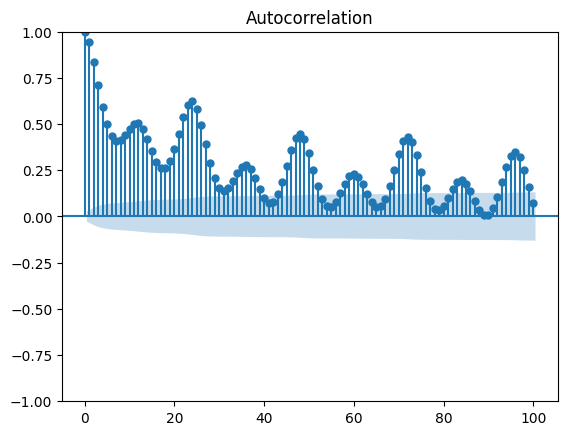

In [8]:
def plot_acf_graph(plot_data,col):
    """
    This function plots acf graph 
    Parameters:
    plot_data (DataFrame): The data on which the acf graph is to be plotted.
    col (str): Column on which the analysis is to be performed.

    Returns:
    return_type: ACF plot.
    """
    return plot_acf(plot_data[col],lags=100)
acf_analysis = plot_acf_graph(deutschland_df,'Deutschland/Luxemburg [€/MWh] Originalauflösungen')

**We can see that the Value at Lag 2 shows significant effect with the current value. Hence we can fit a seasonal model with lag 2**  

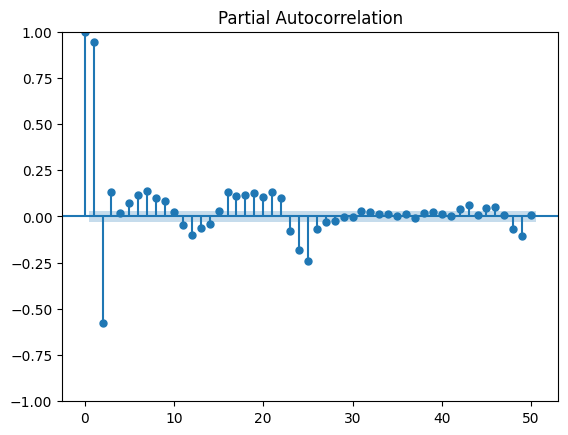

In [9]:
def plot_pacf_graph(plot_data,col):
    """
    This function plots PACF graph 
    Parameters:
    plot_data (DataFrame): The data on which the PACF graph is to be plotted.
    col (str): Column on which the analysis is to be performed.

    Returns:
    return_type: PACF plot.
    """
    return plot_pacf(plot_data[col], lags=50)
    
pacf_analysis = plot_pacf_graph(deutschland_df,'Deutschland/Luxemburg [€/MWh] Originalauflösungen')

### ADF Test
The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine if a time series is stationary or non-stationary.

If the p-value is below (0.05) then the data is stationary or else its non-stationary data.

Here based on the p value we can say that the data is stationary

In [10]:
def adf_check(check_data,col):
    """
    This function performs ADF test for stationarity 
    Parameters:
    check_data (DataFrame): The data on which stationarity is to be checked.
    col (str): Column on which the analysis is to be performed.

    Returns:
    return_type: ADF statistics and p-value.
    """
    return adfuller(check_data[col])
adf_result = adf_check(deutschland_df,'Deutschland/Luxemburg [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ adf_result[0]},'p-value': {adf_result[1]}")

'The values for ADF Statistic':-8.246373093228721,'p-value': 5.539977750530473e-13


### Seasonal Decompisition analysis

The Seasonal data gives the information about the trend, Seasonality and Residual in the data.
The Residual gives the information about the noise in the data after removing the trend and seasonality from the data

In [11]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.
    
    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series. Must be used if x is not a pandas object or if
        the index of x does not have  a frequency. Overrides default
        periodicity of x if x is a pandas object with a timeseries index.
    two_sided : bool, optional
        The moving a

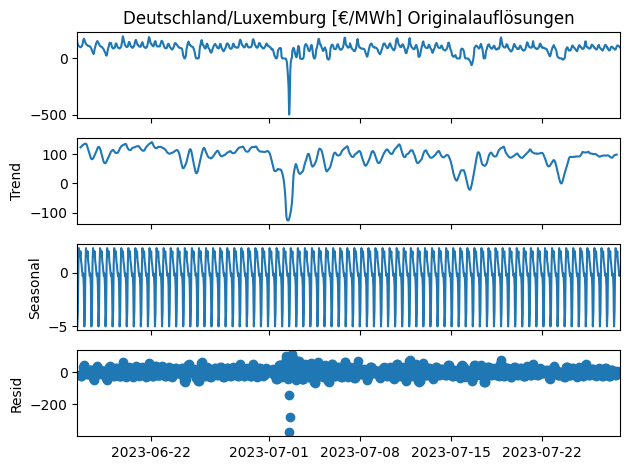

In [12]:
def perform_seasonal_decomposition(seasonal_data,col,period):
    """
    This function plots seasonal decomposition on the data
    Parameters:
    seasonal_data (DataFrame): The data on which the seasonal decompoistion plot is to be plotted.
    col (str): Column on which the analysis is to be performed.
    period (int): Nummber of periods

    Returns:
    return_type: Seasonal Decompistion plot.
    """
    return sm.tsa.seasonal_decompose(seasonal_data[col],period=period, model='additive').plot()

deutschland_df.index = pd.to_datetime(deutschland_df['Timestamp'])
deutschland_df = deutschland_df.tail(1000)
decomposition = perform_seasonal_decomposition(seasonal_data = deutschland_df, col = 'Deutschland/Luxemburg [€/MWh] Originalauflösungen', period= 13 )

### Model Fitting

For the trainning purpose the model is splitted as 80% for trainning 20% for validation. 

**Note here the test_data is the validation dataset**

In [13]:
def train_test_split(split_data, ratio):
    """
    This function does train test split on the data
    Parameters:
    split_data (DataFrame): DataFrame which is to be splitted.
    ratio (float): Ratio on which the split is to be done.
    
    Returns:
    return_type: trainning and testing data.
    """
    train_size = int(ratio * len(split_data))
    train_data = split_data[:train_size]
    test_data = split_data[train_size:]
    return train_data, test_data
        

train_data, test_data = train_test_split(deutschland_df, 0.8) 

In [14]:
def train_arima_model(train_data, col,p,q,d,P,Q,D,M):
    """
    This function train the arima model
    Parameters:
    train_data (DataFrame): DataFrame which is to be splitted.
    col (str): Ratio on which the split is to be done.
    p (int): Number of lag observations included in the model (AutoRegressive order).
    d (int): Number of times raw observations are differenced (Integration order).
    q (int): Size of the moving average window (Moving Average order).
    P (int): Number of lag observations of the seasonal dataset (Seasonal AutoRegressive order).
    D (int): Number of times the seasonal dataset is differenced (Seasonal Integration order).
    Q (int): Size of the moving average window applied to the seasonal dataset (Seasonal Moving Average order).

    Returns:
    return_type: trained model
    """
    model = pm.ARIMA(order=(p, q, d), seasonal_order=(P, Q, D, M), suppress_warnings=True)
    model.fit(train_data[col])
    return model


def model_forecast(trained_model,forecast_period):
    """
    This function forecast the values using the trained model
    Parameters:
    trained_model (model): Trianed model.
    forecast_period (int): Period for which the prediction is to be done.
    
    Returns:
    return_type: Forecasted Values.
    """
    return trained_model.predict(n_periods=forecast_period, return_conf_int=True)


def accuracy_check(forecasted_values, test_data_values):
    """
    This function gives the RMSE values
    Parameters:
    forecasted_values (float): Forecasted Values.
    test_data_values (float): Original Values.
    
    Returns:
    return_type: RMSE Values.
    """
    mse = np.mean((forecasted_values - test_data_values) ** 2)
    rmse = np.sqrt(mse)
    return mse, rmse

def plot_forecast(train_data ,test_data, forecasted_values, column_name):
    """
    This function plotes the data
    Parameters:
    train_data (DataFrame): Forecasted Values.
    test_data (DataFrame): Original Values.
    forecasted_values (list): List of forecasted values 
    column_name (str): Column to be plotted
    
    Returns:
    return_type: Plotly plot of trainning, testing and forecasted data
    """
    plt.figure(figsize=(20, 6))
    ax = plt.gca()
    
    # Plot training data
    ax.plot(train_data['Timestamp'], train_data[column_name], label='Training Data', color='blue')
    
    # Plot testing data
    ax.plot(test_data['Timestamp'], test_data[column_name], label='Testing Data', color='green')
    
    # Plot forecasted values
    ax.plot(test_data['Timestamp'], forecasted_values, label='Forecasted Values', color='red')
    
    # Set plot title and labels
    ax.set_title('ARIMAX Forecast')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Value')
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Show the plot
    plt.show()

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

Root Mean Squared Error (RMSE): 28.385347440723844  €


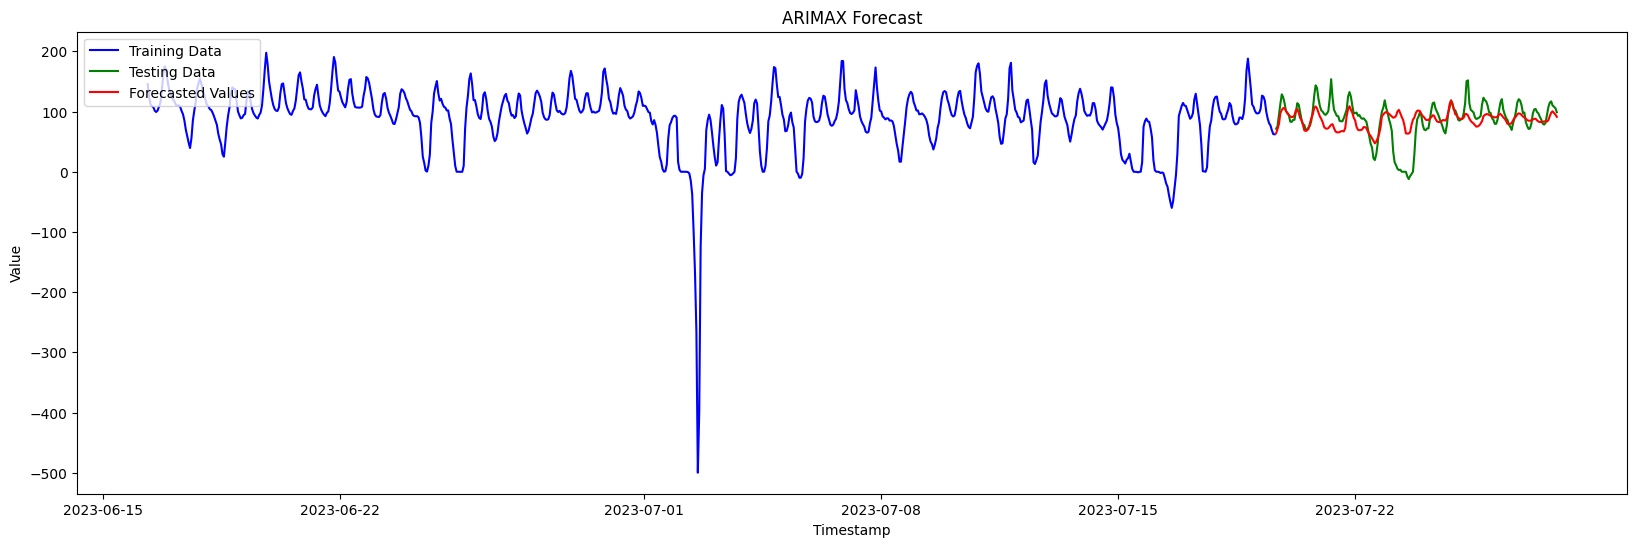

In [15]:
model = train_arima_model(train_data, 'Deutschland/Luxemburg [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Deutschland/Luxemburg [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse,' €')
plot_forecast(train_data,test_data,forecast_values,'Deutschland/Luxemburg [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [16]:
# model = train_arima_model(deutschland_df, 'Deutschland/Luxemburg [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)

### Save model

In [17]:
def save_model(saving_name, model_name):
    with open(fr'./model/{saving_name}', 'wb') as f:
            pickle.dump(model_name, f)

In [18]:
save_model('deutschland.pkl',model)

##  Analysis for Anrainer DE/LU 

### ACF Analysis

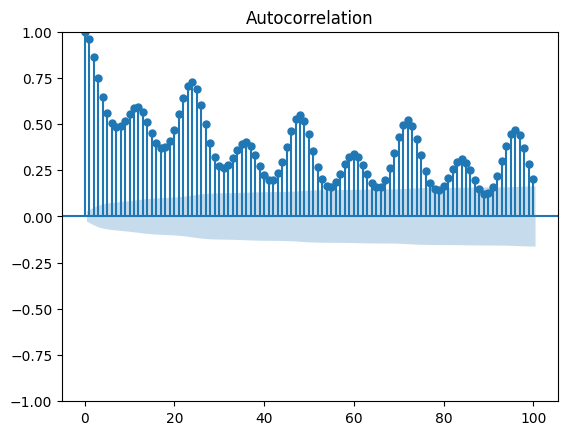

In [19]:
anrainer_df = data[['Timestamp','∅ Anrainer DE/LU [€/MWh] Originalauflösungen']].copy(deep=True)

anrainer_acf = plot_acf_graph(anrainer_df,'∅ Anrainer DE/LU [€/MWh] Originalauflösungen')

### PACF Analysis

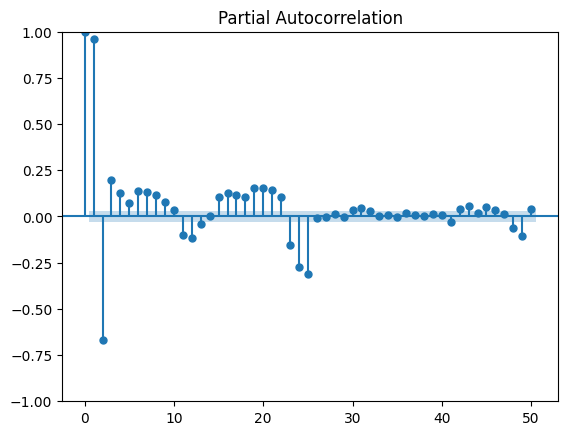

In [20]:
anrainer_pacf = plot_pacf_graph(anrainer_df,'∅ Anrainer DE/LU [€/MWh] Originalauflösungen')

### ADF Test

In [21]:
anrainer_adf = adf_check(anrainer_df,'∅ Anrainer DE/LU [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ anrainer_adf[0]},'p-value': {anrainer_adf[1]}")

'The values for ADF Statistic':-6.2175848401163,'p-value': 5.319222677797869e-08


### Seasonal Decomposition

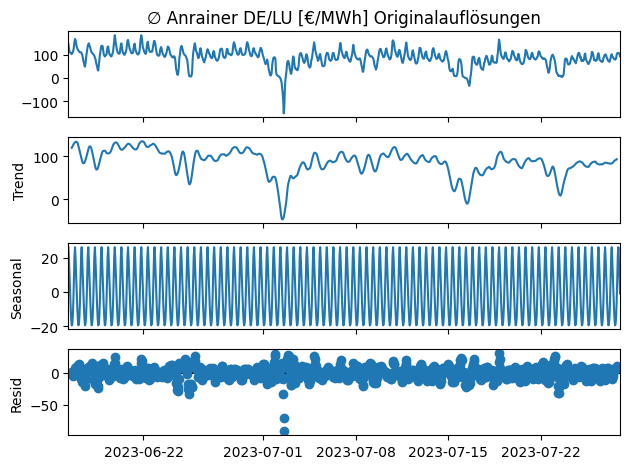

In [22]:
anrainer_df.index = pd.to_datetime(anrainer_df['Timestamp'])
anrainer_df = anrainer_df.tail(1000)
anrianer_seasonal_decompose = perform_seasonal_decomposition(anrainer_df,'∅ Anrainer DE/LU [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 21.900414767211444


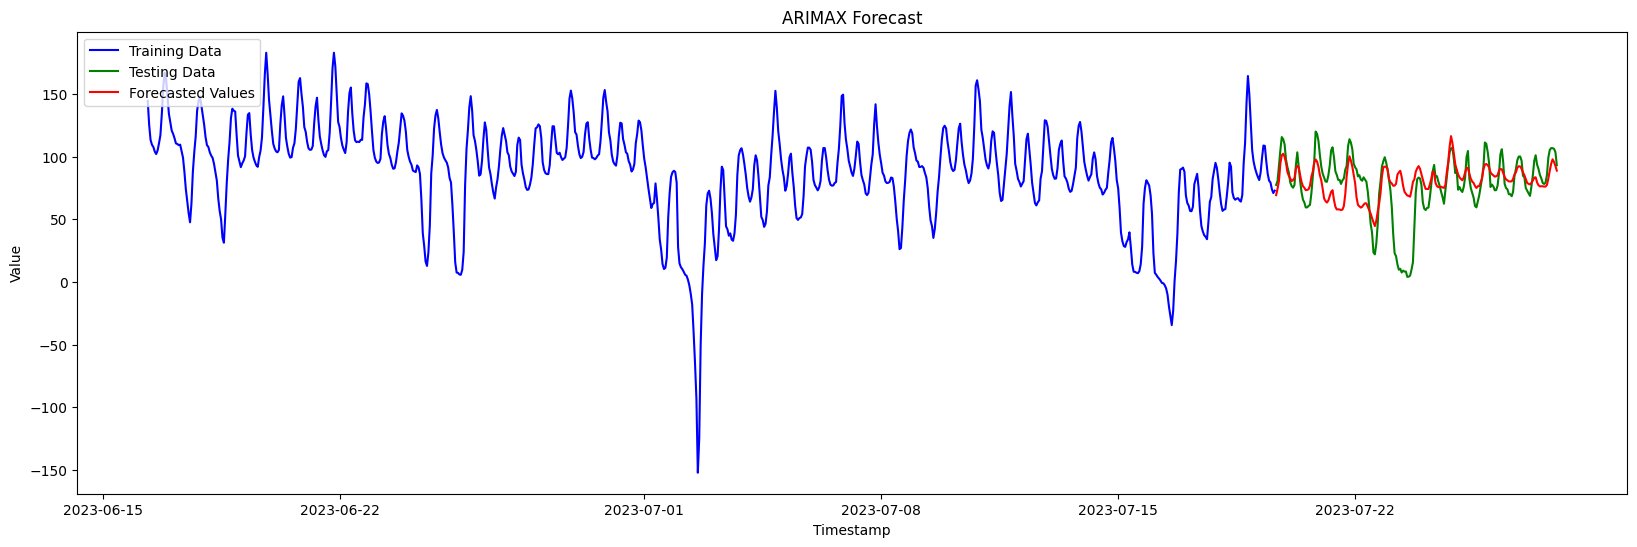

In [23]:
train_data, test_data = train_test_split(anrainer_df, 0.8) 

anrainer_model = train_arima_model(train_data, '∅ Anrainer DE/LU [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= anrainer_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['∅ Anrainer DE/LU [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'∅ Anrainer DE/LU [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [24]:
# anrainer_model = train_arima_model(anrainer_df, '∅ Anrainer DE/LU [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
# save_model('arainer.pkl',anrainer_model)

##  Analysis for Belgien

### ACF Analysis

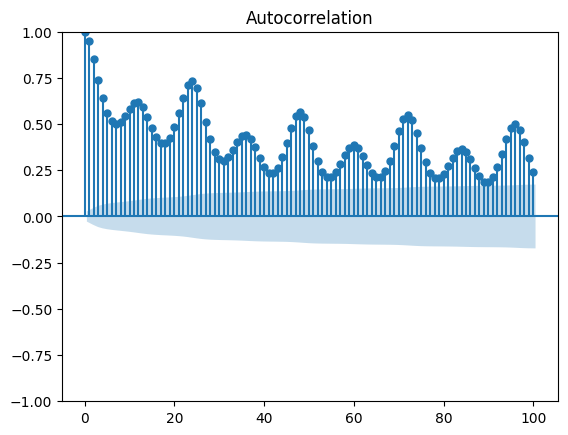

In [25]:
belgien = data[['Timestamp','Belgien [€/MWh] Originalauflösungen']].copy(deep=True)

belgien_acf = plot_acf_graph(belgien,'Belgien [€/MWh] Originalauflösungen')

### PACF Analysis

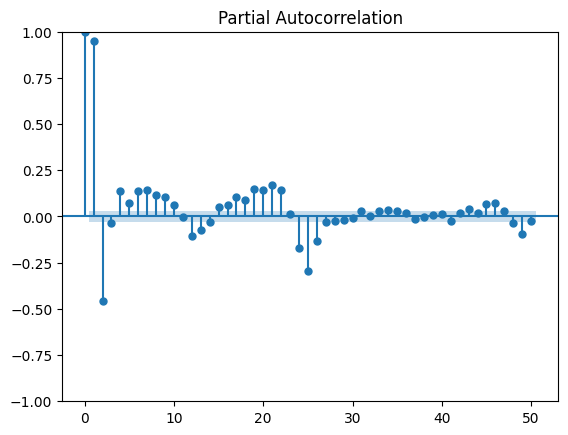

In [26]:
belgien_pacf = plot_pacf_graph(belgien,'Belgien [€/MWh] Originalauflösungen')

### ADF Test

In [27]:
belgien_adf = adf_check(belgien,'Belgien [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ belgien_adf[0]},'p-value': {belgien_adf[1]}")

'The values for ADF Statistic':-6.686194559399869,'p-value': 4.220162779281001e-09


### Seasonal Decomposition

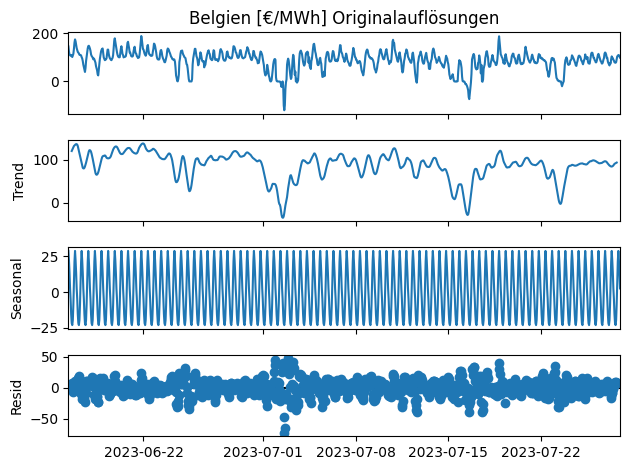

In [28]:
belgien.index = pd.to_datetime(belgien['Timestamp'])
belgien = belgien.tail(1000)
belgien_seasonal_decompose = perform_seasonal_decomposition(belgien,'Belgien [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 25.799099911356628


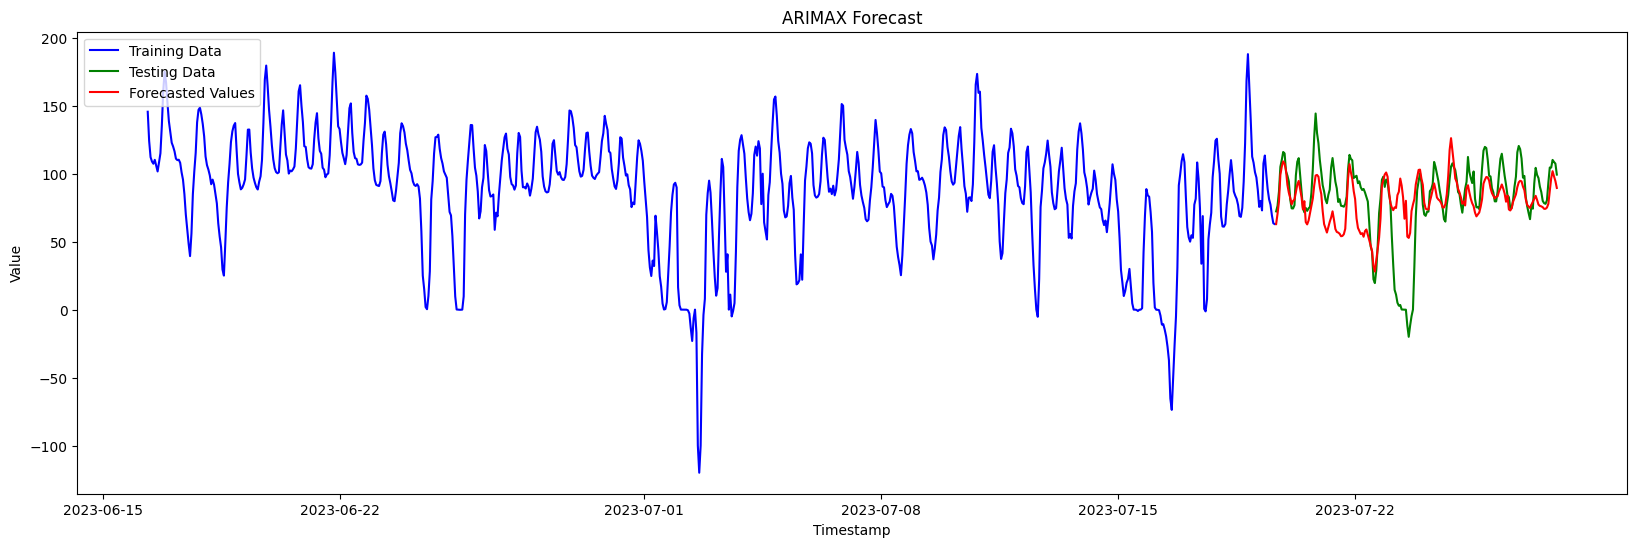

In [29]:
train_data, test_data = train_test_split(belgien, 0.8) 

belgien_model = train_arima_model(train_data, 'Belgien [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= belgien_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Belgien [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Belgien [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data.

Uncomment code to save the model again

In [30]:
# belgien_model = train_arima_model(belgien, 'Belgien [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
# save_model('belgien.pkl',belgien_model)

##  Analysis for Dänemark 1

### ACF Analysis

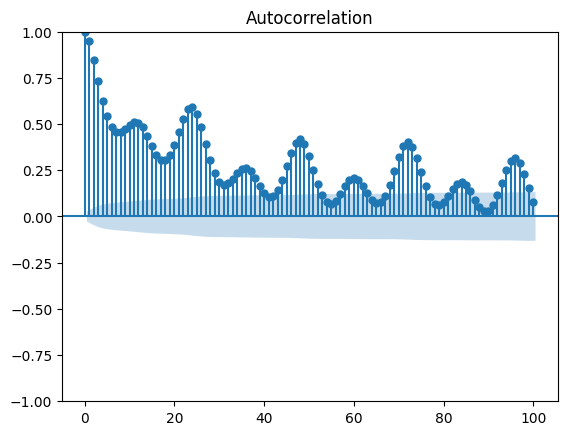

In [31]:
dänemark_1_df = data[['Timestamp','Dänemark 1 [€/MWh] Originalauflösungen']].copy(deep=True)

dänemark_1_acf = plot_acf_graph(dänemark_1_df,'Dänemark 1 [€/MWh] Originalauflösungen')

### PACF Analysis

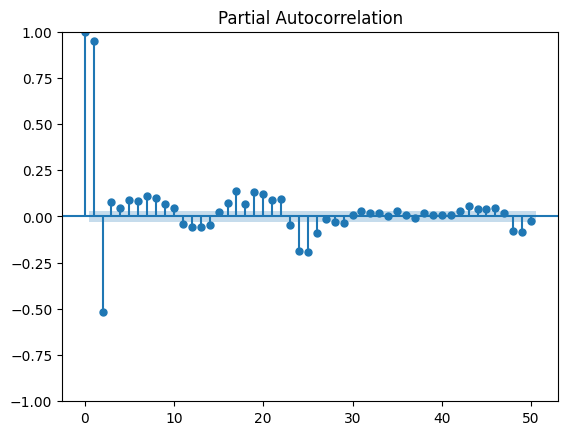

In [32]:
dänemark_1_pacf = plot_pacf_graph(dänemark_1_df,'Dänemark 1 [€/MWh] Originalauflösungen')

### ADF Test

In [33]:
dänemark_1_adf = adf_check(dänemark_1_df,'Dänemark 1 [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ dänemark_1_adf[0]},'p-value': {dänemark_1_adf[1]}")

'The values for ADF Statistic':-8.507805118299054,'p-value': 1.1897521542655602e-13


### Seasonal Decomposition

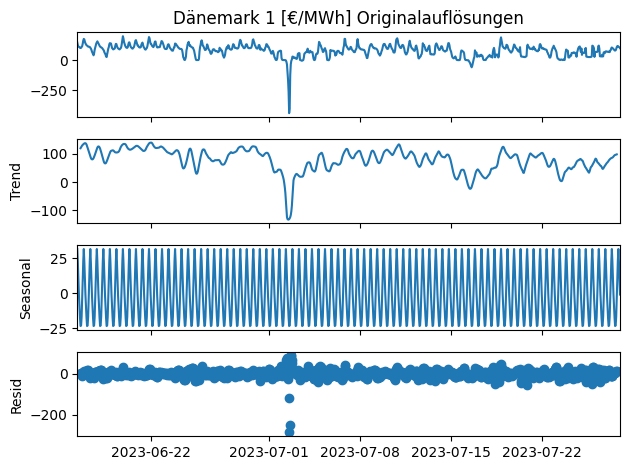

In [34]:
dänemark_1_df.index = pd.to_datetime(dänemark_1_df['Timestamp'])
dänemark_1_df = dänemark_1_df.tail(1000)
dänemark_1_seasonal_decompose = perform_seasonal_decomposition(dänemark_1_df,'Dänemark 1 [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 29.834247349155955


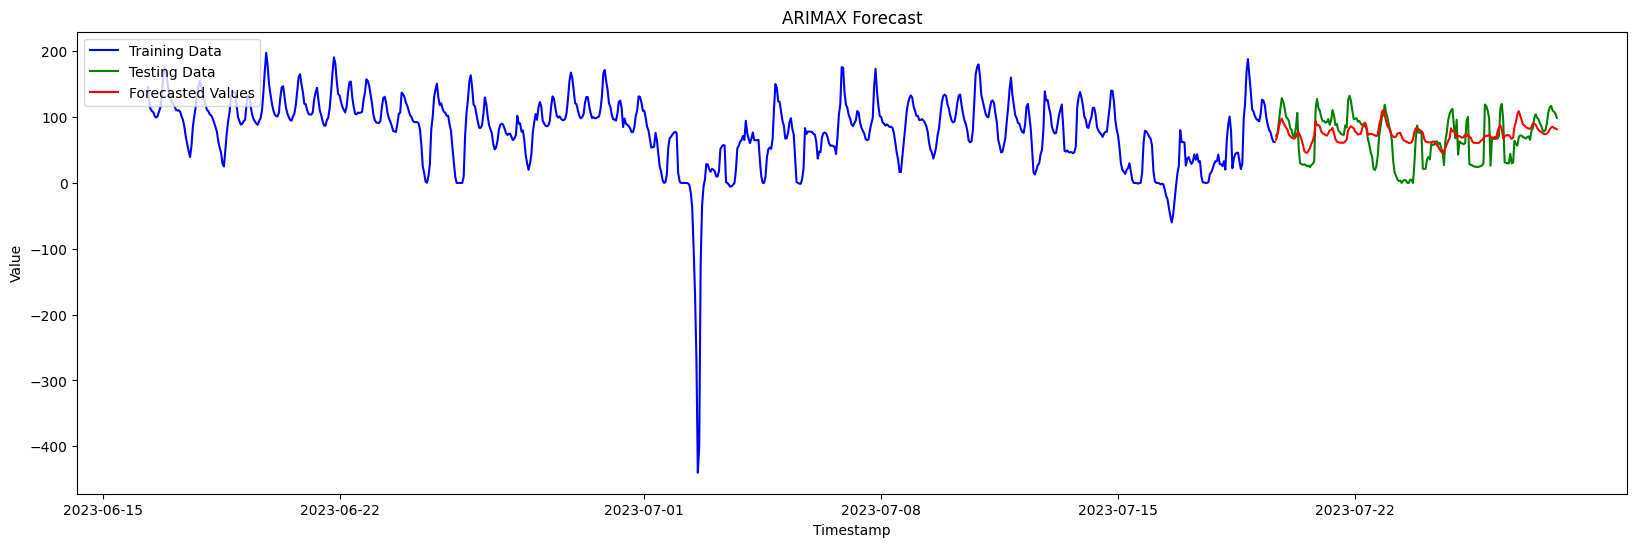

In [35]:
train_data, test_data = train_test_split(dänemark_1_df, 0.8) 

dänemark_1_model = train_arima_model(train_data, 'Dänemark 1 [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=96)
forecast_values, conf_int = model_forecast(trained_model= dänemark_1_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Dänemark 1 [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Dänemark 1 [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [36]:
# dänemark_1_model = train_arima_model(dänemark_1_df, 'Dänemark 1 [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=96)
# save_model('dänemark_1.pkl',dänemark_1_model)

##  Analysis for Dänemark 2

### ACF Analysis

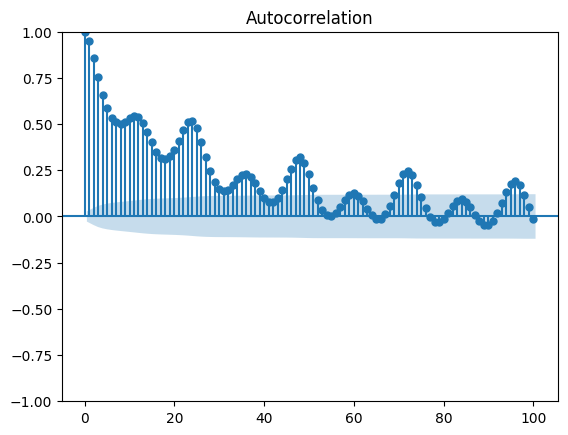

In [37]:
dänemark_2_df = data[['Timestamp','Dänemark 2 [€/MWh] Originalauflösungen']].copy(deep=True)

dänemark_2_acf = plot_acf_graph(dänemark_2_df,'Dänemark 2 [€/MWh] Originalauflösungen')

### PACF Analysis

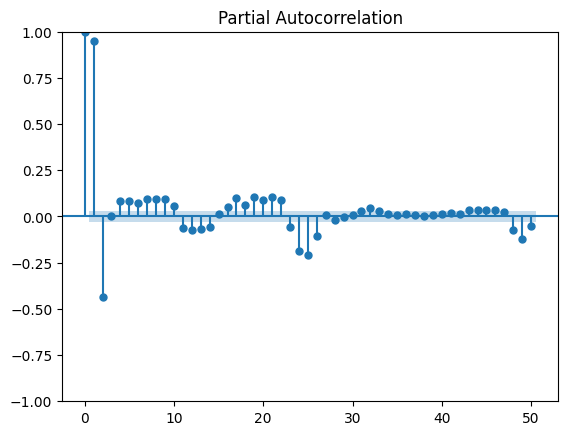

In [38]:
dänemark_2_pacf = plot_pacf_graph(dänemark_2_df,'Dänemark 2 [€/MWh] Originalauflösungen')

### ADF Test

In [39]:
dänemark_2_adf = adf_check(dänemark_2_df,'Dänemark 2 [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ dänemark_2_adf[0]},'p-value': {dänemark_2_adf[1]}")

'The values for ADF Statistic':-8.106230620235435,'p-value': 1.2607134896993836e-12


### Seasonal Decomposition

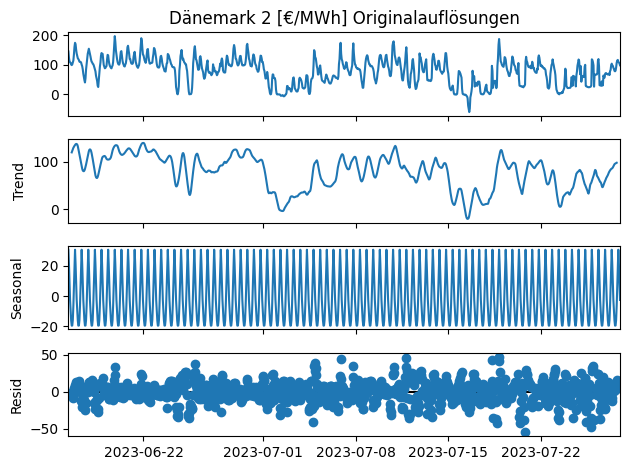

In [40]:
dänemark_2_df.index = pd.to_datetime(dänemark_2_df['Timestamp'])
dänemark_2_df = dänemark_2_df.tail(1000)
dänemark_2_seasonal_decompose = perform_seasonal_decomposition(dänemark_2_df,'Dänemark 2 [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 31.12155629861549


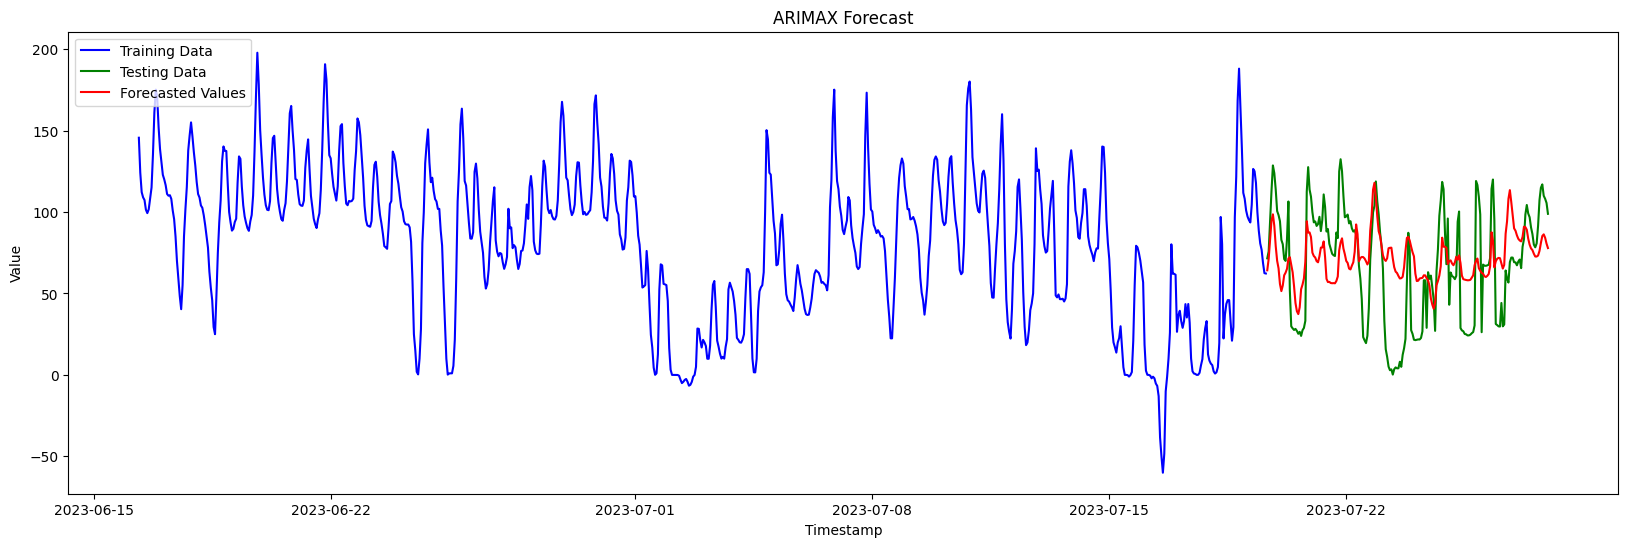

In [41]:
train_data, test_data = train_test_split(dänemark_2_df, 0.8) 

dänemark_2_model = train_arima_model(train_data, 'Dänemark 2 [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=96)
forecast_values, conf_int = model_forecast(trained_model= dänemark_2_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Dänemark 2 [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Dänemark 2 [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [42]:
# dänemark_2_model = train_arima_model(dänemark_2_df, 'Dänemark 2 [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=96)
# save_model('dänemark_2.pkl',dänemark_2_model)

##  Analysis for Frankreich

### ACF Analysis

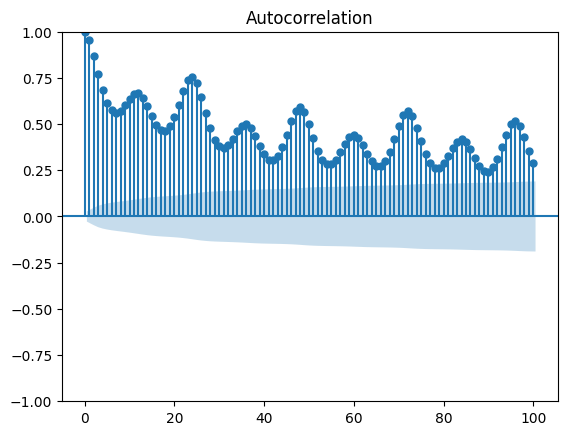

In [43]:
frankreich_df = data[['Timestamp','Frankreich [€/MWh] Originalauflösungen']].copy(deep=True)

frankreich_acf = plot_acf_graph(frankreich_df,'Frankreich [€/MWh] Originalauflösungen')

### PACF Analysis

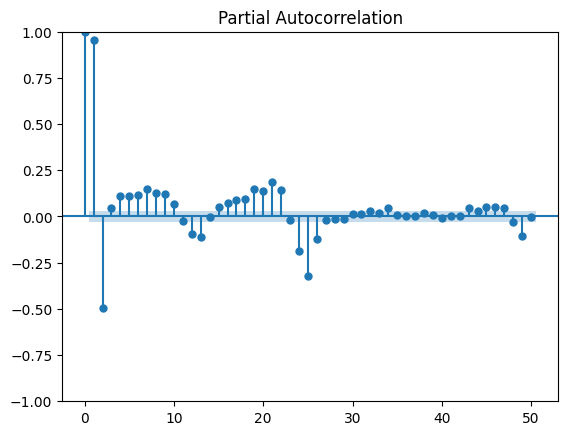

In [44]:
frankreich_pacf = plot_pacf_graph(frankreich_df,'Frankreich [€/MWh] Originalauflösungen')

### ADF Test

In [45]:
frankreich_adf = adf_check(frankreich_df,'Frankreich [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ frankreich_adf[0]},'p-value': {frankreich_adf[1]}")

'The values for ADF Statistic':-6.259814100524611,'p-value': 4.250394021281046e-08


### Seasonal Decomposition

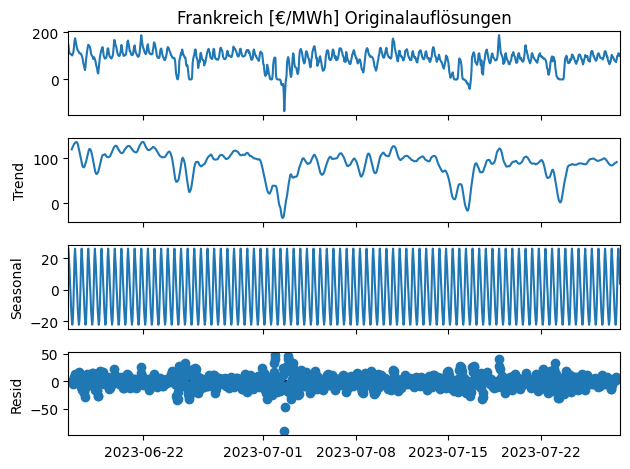

In [46]:
frankreich_df.index = pd.to_datetime(frankreich_df['Timestamp'])
frankreich_df = frankreich_df.tail(1000)
frankreich_seasonal_decompose = perform_seasonal_decomposition(frankreich_df,'Frankreich [€/MWh] Originalauflösungen',period=12)

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 26.645955113223042


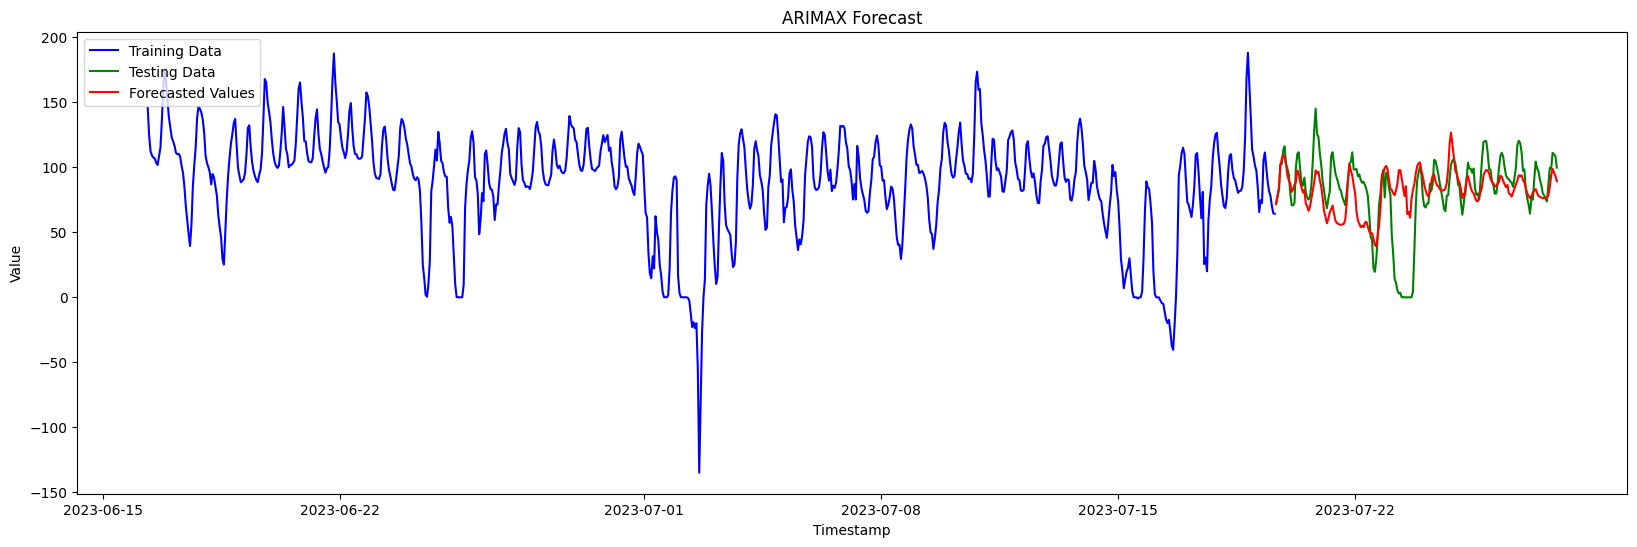

In [47]:
train_data, test_data = train_test_split(frankreich_df, 0.8) 

frankreich_model = train_arima_model(train_data, 'Frankreich [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= frankreich_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Frankreich [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Frankreich [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [48]:
# frankreich_model = train_arima_model(frankreich_df, 'Frankreich [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
# save_model('frankreich.pkl',frankreich_model)

##  Analysis for Niederlande

### ACF Analysis

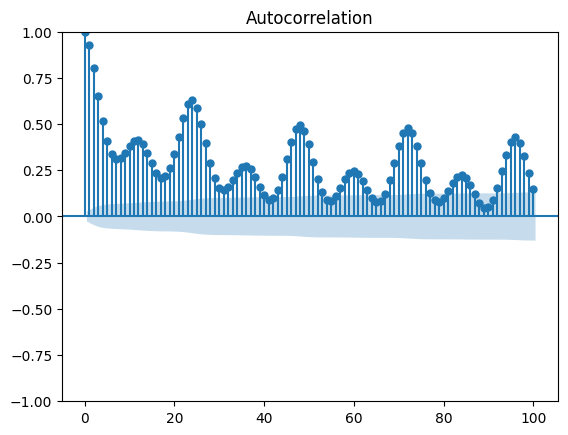

In [49]:
niederlande_df = data[['Timestamp','Niederlande [€/MWh] Originalauflösungen']].copy(deep=True)

niederlande_acf = plot_acf_graph(niederlande_df,'Niederlande [€/MWh] Originalauflösungen')

### PACF Analysis

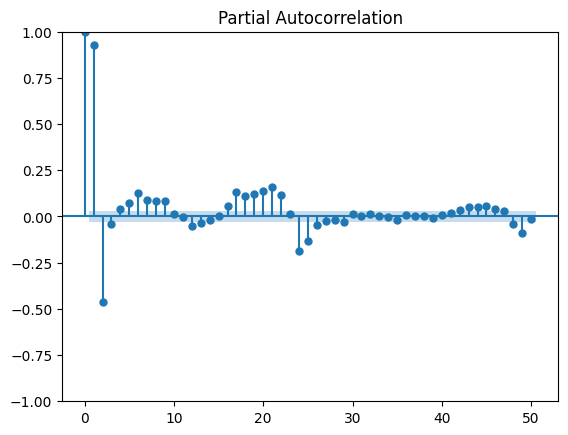

In [50]:
niederlande_pacf = plot_pacf_graph(niederlande_df,'Niederlande [€/MWh] Originalauflösungen')

### ADF Test

In [51]:
niederlande_adf = adf_check(niederlande_df,'Niederlande [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ niederlande_adf[0]},'p-value': {niederlande_adf[1]}")

'The values for ADF Statistic':-6.9921636657537105,'p-value': 7.695146787635717e-10


### Seasonal Decomposition

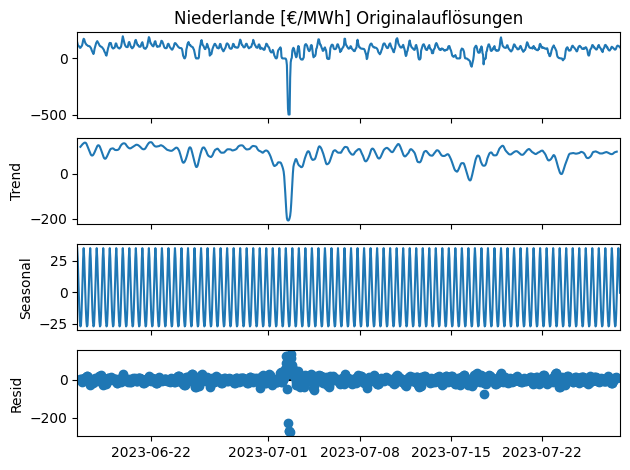

In [52]:
niederlande_df.index = pd.to_datetime(niederlande_df['Timestamp'])
niederlande_df = niederlande_df.tail(1000)
niederlande_seasonal_decompose = perform_seasonal_decomposition(niederlande_df,'Niederlande [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 26.1387979136425


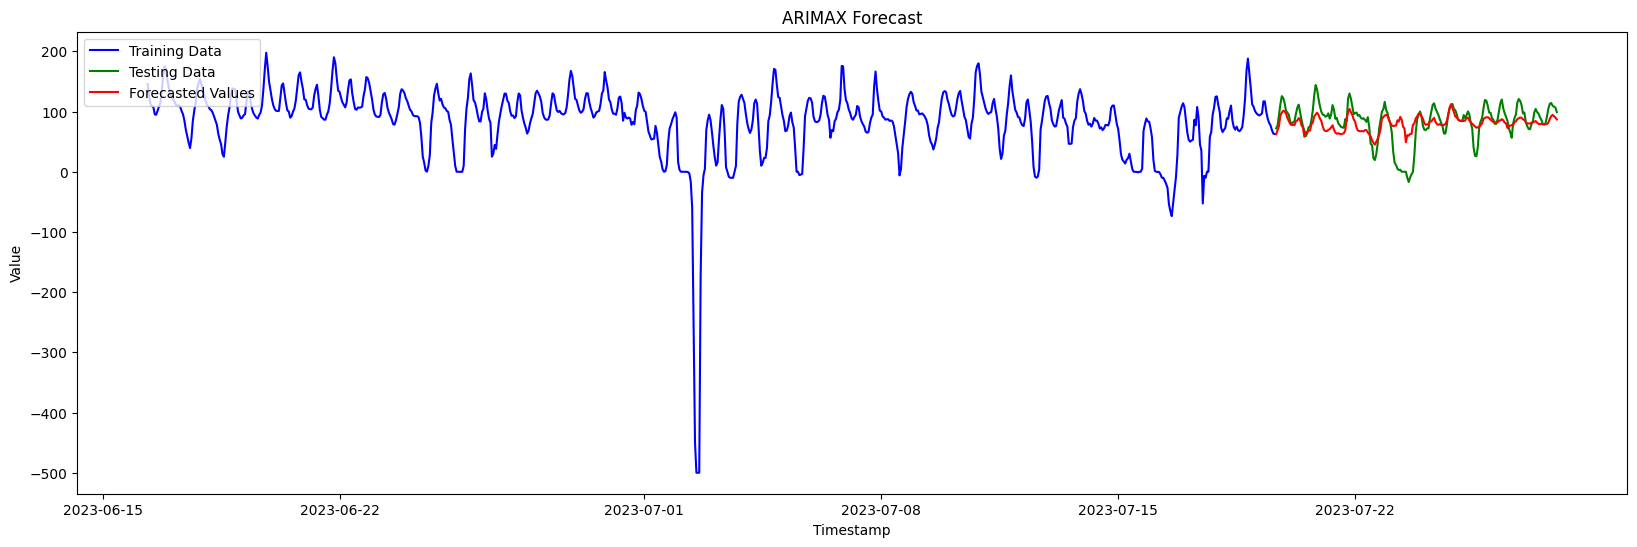

In [53]:
train_data, test_data = train_test_split(niederlande_df, 0.8) 

niederlande_model = train_arima_model(train_data, 'Niederlande [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= niederlande_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Niederlande [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Niederlande [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [54]:
# niederlande_model = train_arima_model(niederlande_df, 'Niederlande [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
# save_model('niederlande.pkl',niederlande_model)

##  Analysis for Norwegen

### ACF Analysis

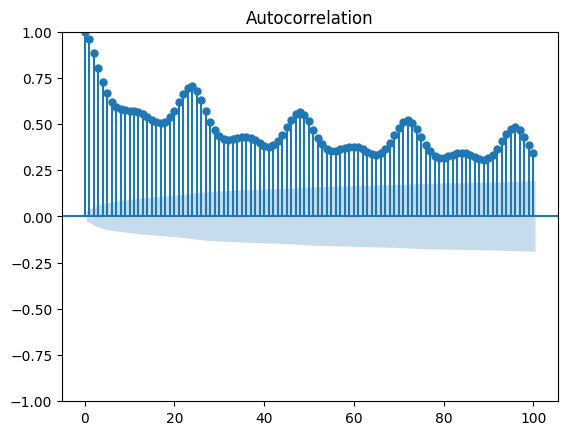

In [55]:
norwegen_df = data[['Timestamp','Norwegen 2 [€/MWh] Originalauflösungen']].copy(deep=True)

norwegen_acf = plot_acf_graph(norwegen_df,'Norwegen 2 [€/MWh] Originalauflösungen')

### PACF Analysis

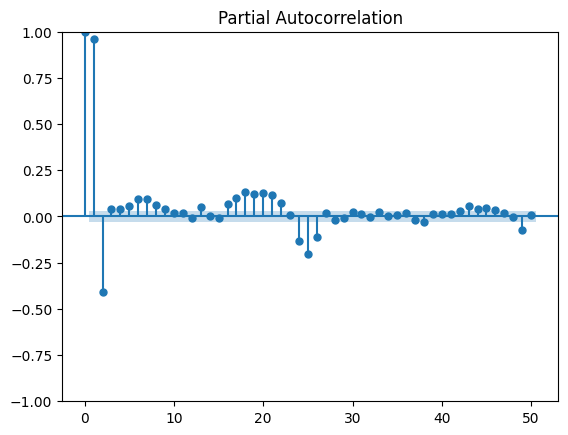

In [56]:
norwegen_pacf = plot_pacf_graph(norwegen_df,'Norwegen 2 [€/MWh] Originalauflösungen')

### ADF Test

In [57]:
norwegen_adf = adf_check(norwegen_df,'Norwegen 2 [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ norwegen_adf[0]},'p-value': {norwegen_adf[1]}")

'The values for ADF Statistic':-5.836544060488826,'p-value': 3.8645874406090805e-07


### Seasonal Decomposition

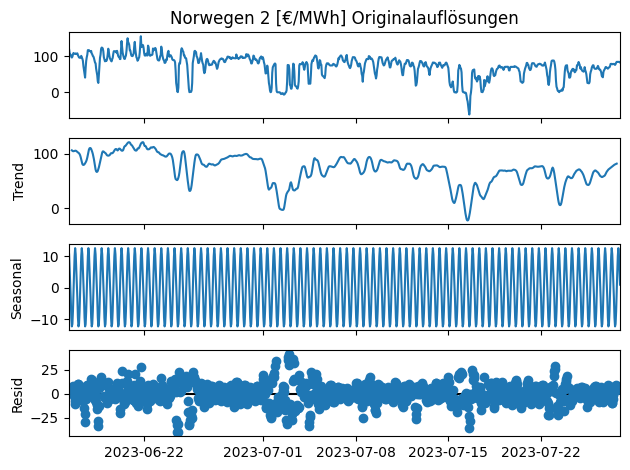

In [58]:
norwegen_df.index = pd.to_datetime(norwegen_df['Timestamp'])
norwegen_df = norwegen_df.tail(1000)
norwegen_seasonal_decompose = perform_seasonal_decomposition(norwegen_df,'Norwegen 2 [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 20.49594947478552


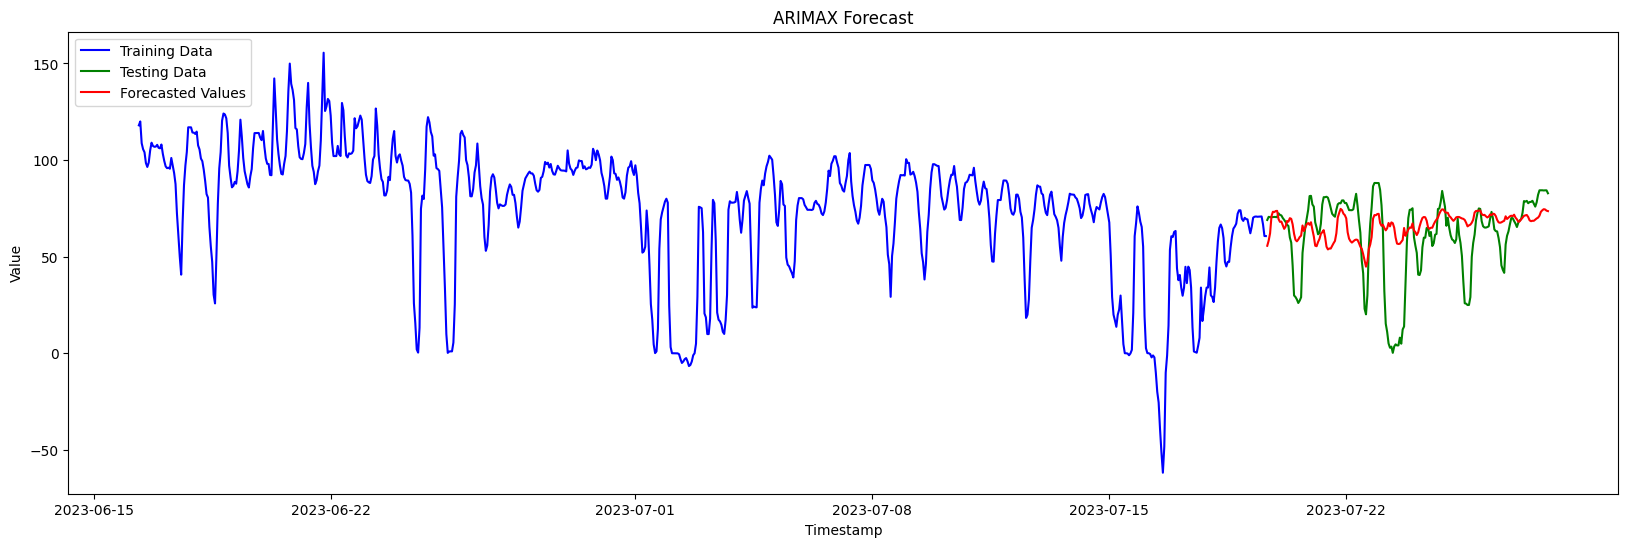

In [59]:
train_data, test_data = train_test_split(norwegen_df, 0.8) 

norwegen_model = train_arima_model(train_data, 'Norwegen 2 [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= norwegen_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Norwegen 2 [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Norwegen 2 [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [60]:
# norwegen_model = train_arima_model(norwegen_df, 'Norwegen 2 [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
# save_model('norwegen.pkl',norwegen_model)

##  Analysis for Österreich

### ACF Analysis

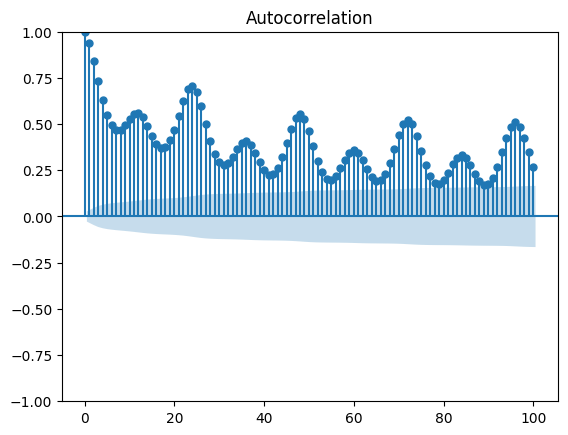

In [61]:
Österreich_df = data[['Timestamp','Österreich [€/MWh] Originalauflösungen']].copy(deep=True)

Österreich_acf = plot_acf_graph(Österreich_df,'Österreich [€/MWh] Originalauflösungen')

### PACF Analysis

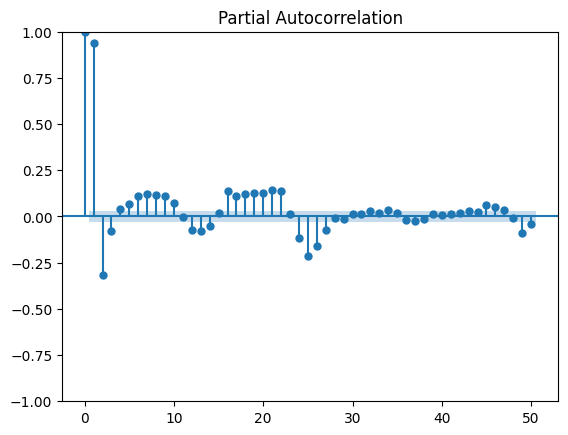

In [62]:
Österreich_pacf = plot_pacf_graph(Österreich_df,'Österreich [€/MWh] Originalauflösungen')

### ADF Test

In [63]:
Österreich_adf = adf_check(Österreich_df,'Österreich [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ Österreich_adf[0]},'p-value': {Österreich_adf[1]}")

'The values for ADF Statistic':-6.478575048429901,'p-value': 1.312278330430128e-08


### Seasonal Decomposition

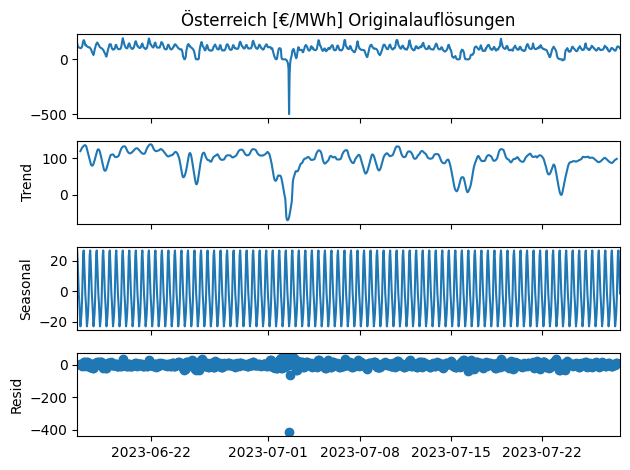

In [64]:
Österreich_df.index = pd.to_datetime(Österreich_df['Timestamp'])
Österreich_df = Österreich_df.tail(1000)
Österreich_seasonal_decompose = perform_seasonal_decomposition(Österreich_df,'Österreich [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 24.957439263769903


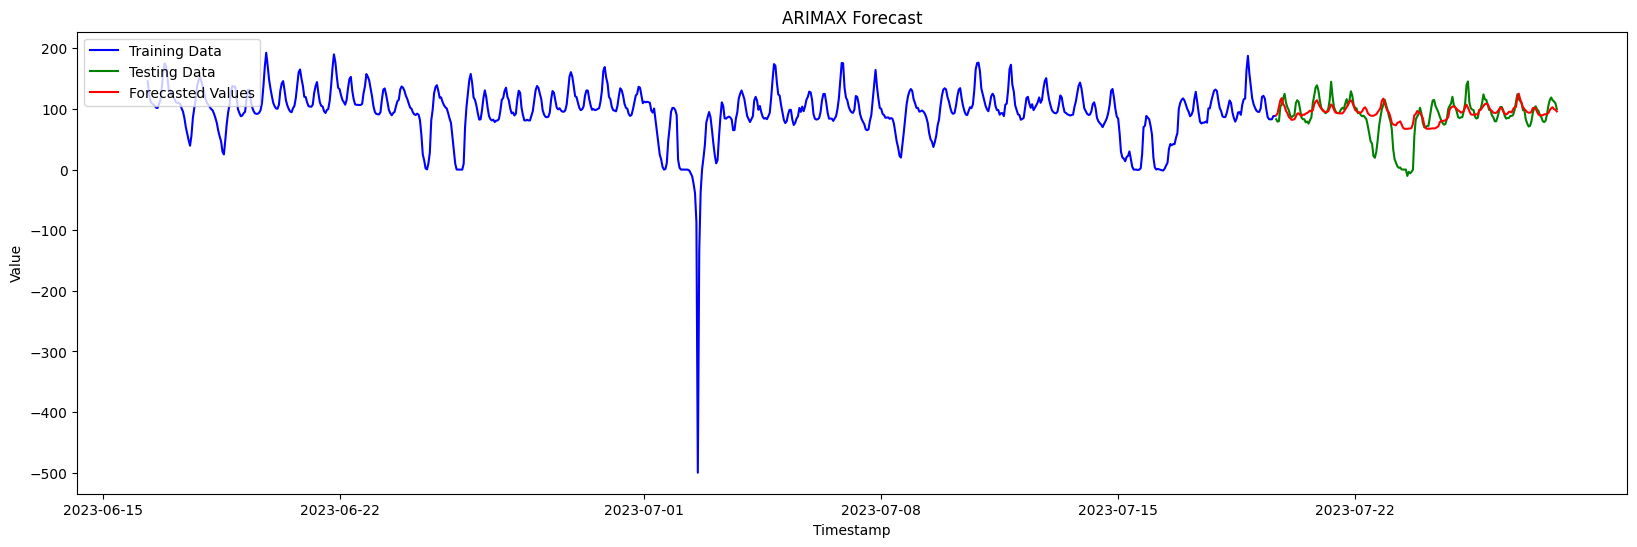

In [65]:
train_data, test_data = train_test_split(Österreich_df, 0.8) 

Österreich_model = train_arima_model(train_data, 'Österreich [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=96)
forecast_values, conf_int = model_forecast(trained_model= Österreich_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Österreich [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Österreich [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [66]:
# Österreich_model = train_arima_model(Österreich_df, 'Österreich [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=96)
# save_model('Österreich.pkl',Österreich_model)

##  Analysis for Polen

### ACF Analysis

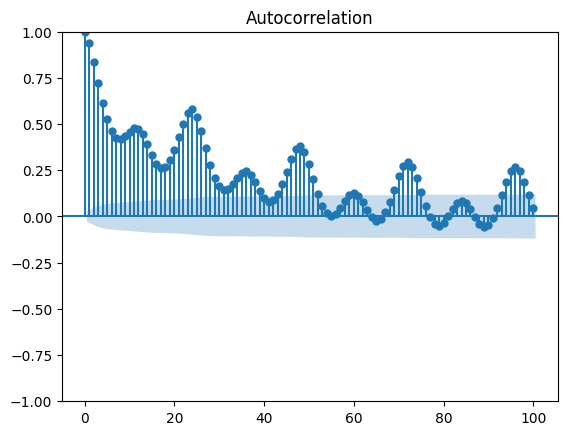

In [67]:
polen_df = data[['Timestamp','Polen [€/MWh] Originalauflösungen']].copy(deep=True)

polen_acf = plot_acf_graph(polen_df,'Polen [€/MWh] Originalauflösungen')

### PACF Analysis

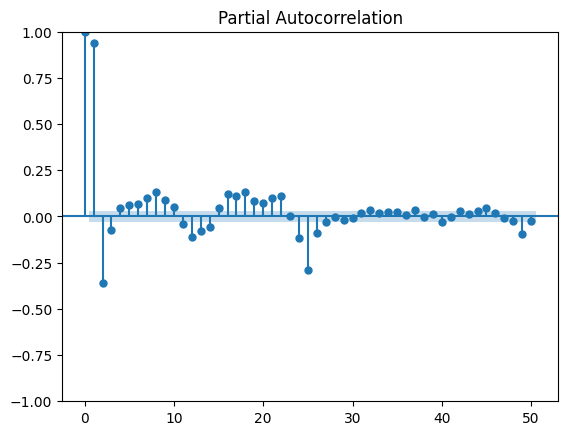

In [68]:
polen_pacf = plot_pacf_graph(polen_df,'Polen [€/MWh] Originalauflösungen')

### ADF Test

In [69]:
polen_adf = adf_check(polen_df,'Polen [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ polen_adf[0]},'p-value': {polen_adf[1]}")

'The values for ADF Statistic':-7.838467165924172,'p-value': 6.0258062327806806e-12


### Seasonal Decomposition

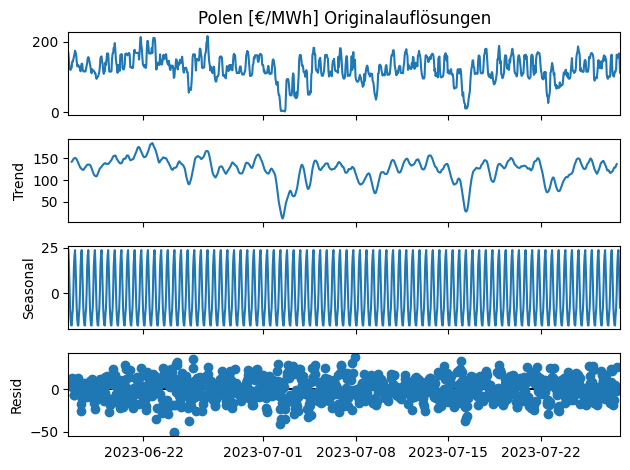

In [70]:
polen_df.index = pd.to_datetime(polen_df['Timestamp'])
polen_df = polen_df.tail(1000)
polen_seasonal_decompose = perform_seasonal_decomposition(polen_df,'Polen [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 27.18449368644242


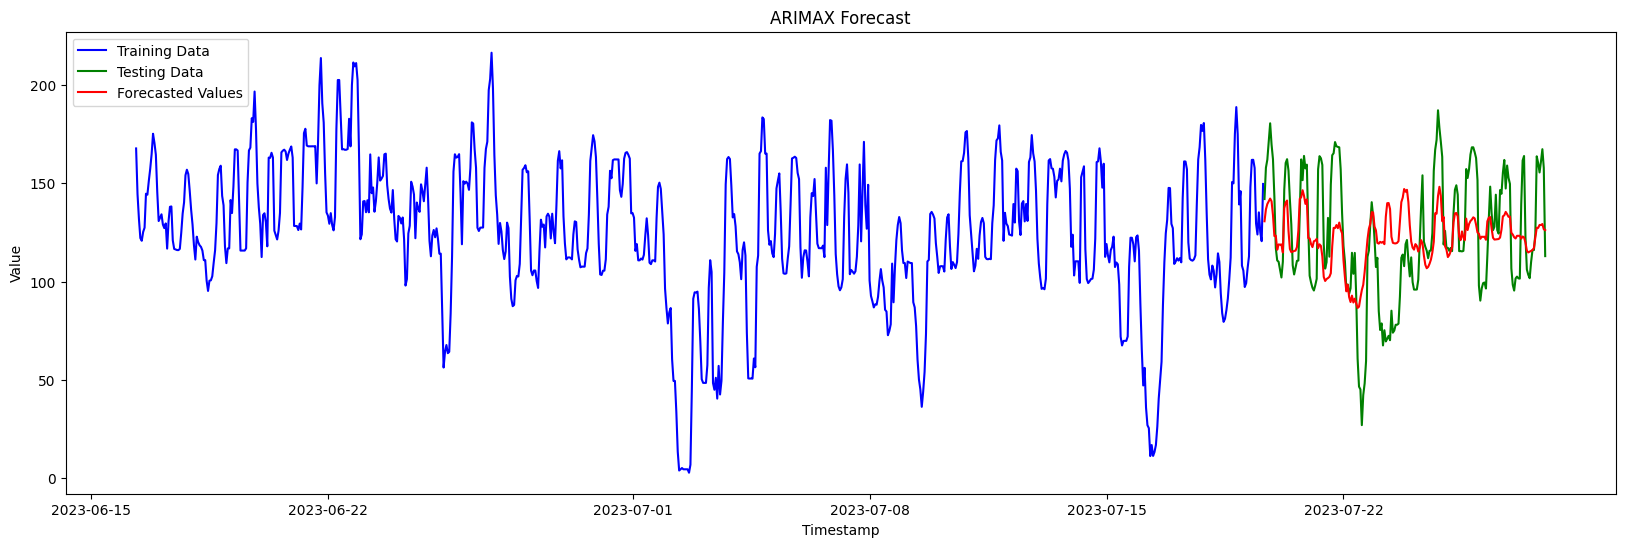

In [71]:
train_data, test_data = train_test_split(polen_df, 0.8) 

polen_model = train_arima_model(train_data, 'Polen [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= polen_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Polen [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Polen [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [72]:
# polen_model = train_arima_model(polen_df, 'Polen [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
# save_model('polen.pkl',polen_model)

##  Analysis for Schweden

### ACF Analysis

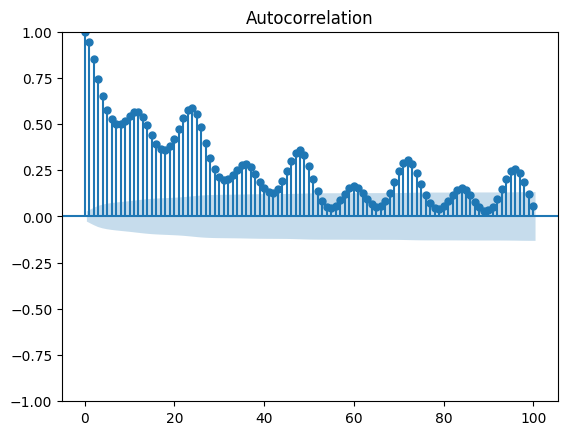

In [73]:
schweden_df = data[['Timestamp','Schweden 4 [€/MWh] Originalauflösungen']].copy(deep=True)

schweden_acf = plot_acf_graph(schweden_df,'Schweden 4 [€/MWh] Originalauflösungen')

### PACF Analysis

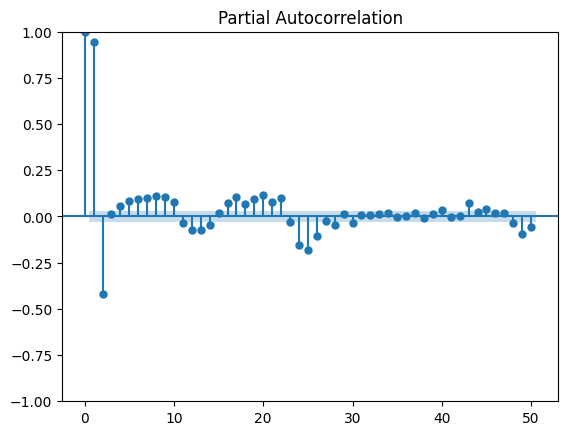

In [74]:
schweden_pacf = plot_pacf_graph(schweden_df,'Schweden 4 [€/MWh] Originalauflösungen')

### ADF Test

In [75]:
schweden_adf = adf_check(schweden_df,'Schweden 4 [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ schweden_adf[0]},'p-value': {schweden_adf[1]}")

'The values for ADF Statistic':-8.268264902795487,'p-value': 4.871349680073229e-13


### Seasonal Decomposition

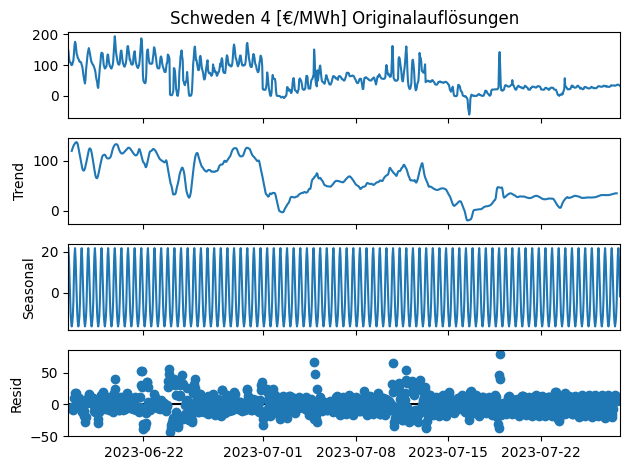

In [76]:
schweden_df.index = pd.to_datetime(schweden_df['Timestamp'])
schweden_df = schweden_df.tail(1000)
schweden_seasonal_decompose = perform_seasonal_decomposition(schweden_df,'Schweden 4 [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 21.578114064912242


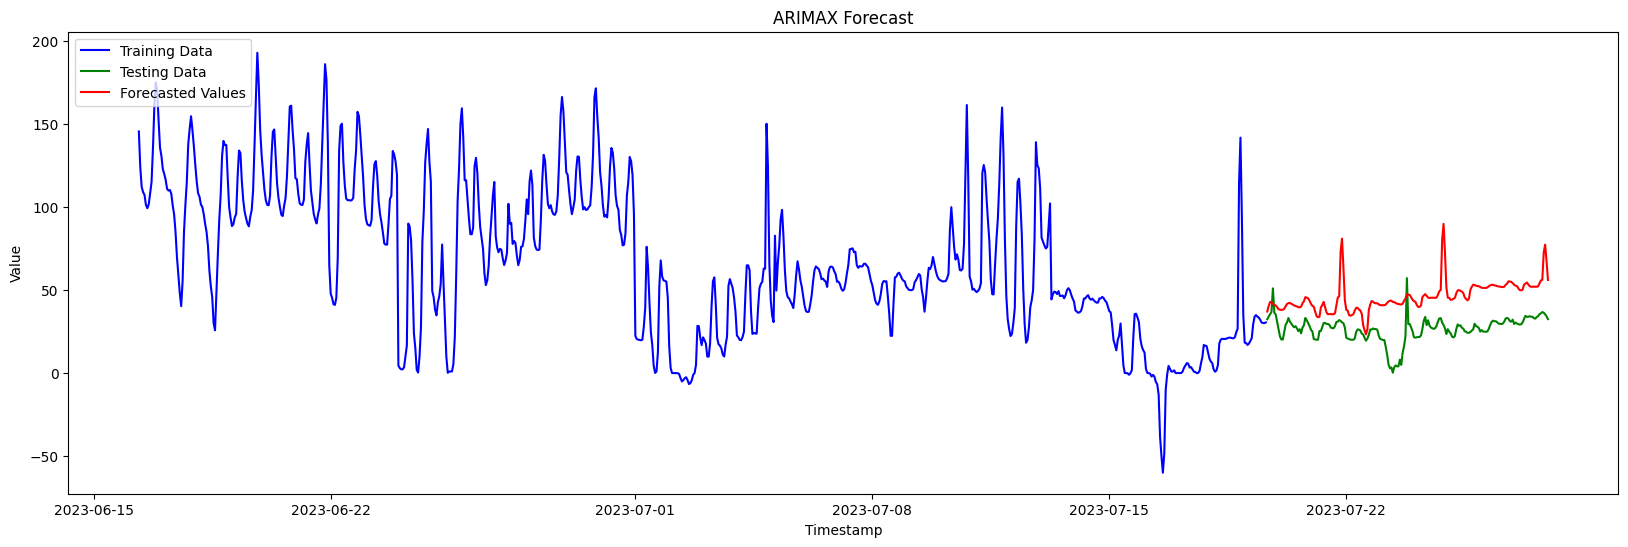

In [77]:
train_data, test_data = train_test_split(schweden_df, 0.8) 

schweden_model = train_arima_model(train_data, 'Schweden 4 [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= schweden_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Schweden 4 [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Schweden 4 [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [78]:
# schweden_model = train_arima_model(schweden_df, 'Schweden 4 [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
# save_model('schweden.pkl',schweden_model)

##  Analysis for Schweiz

### ACF Analysis

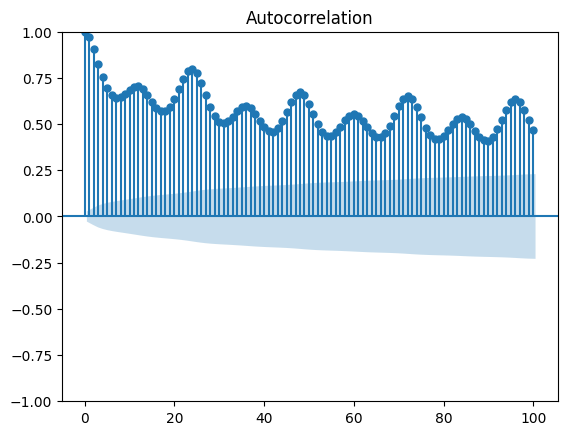

In [79]:
schweiz_df = data[['Timestamp','Schweiz [€/MWh] Originalauflösungen']].copy(deep=True)

schweiz_acf = plot_acf_graph(schweiz_df,'Schweiz [€/MWh] Originalauflösungen')

### PACF Analysis

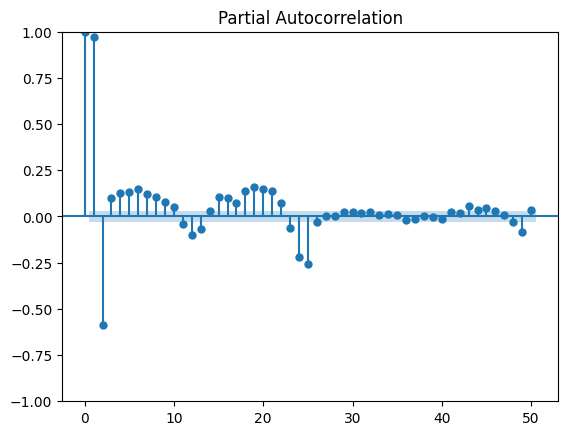

In [80]:
schweiz_pacf = plot_pacf_graph(schweiz_df,'Schweiz [€/MWh] Originalauflösungen')

### ADF Test

In [81]:
schweiz_adf = adf_check(schweiz_df,'Schweiz [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ schweiz_adf[0]},'p-value': {schweiz_adf[1]}")

'The values for ADF Statistic':-4.99056583030547,'p-value': 2.3167324773638687e-05


### Seasonal Decomposition

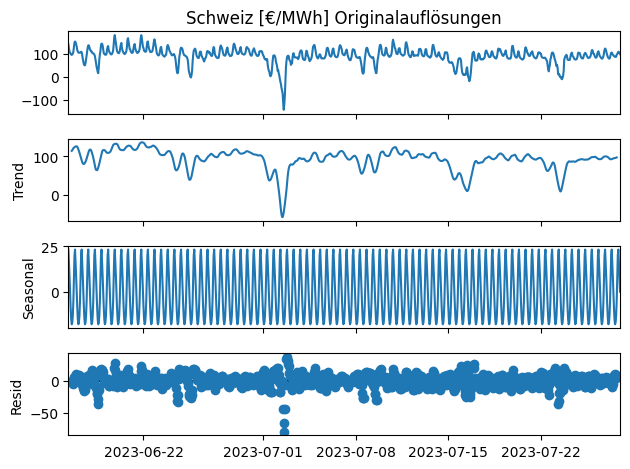

In [82]:
schweiz_df.index = pd.to_datetime(schweiz_df['Timestamp'])
schweiz_df = schweiz_df.tail(1000)
schweiz_seasonal_decompose = perform_seasonal_decomposition(schweiz_df,'Schweiz [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 23.918607088757767


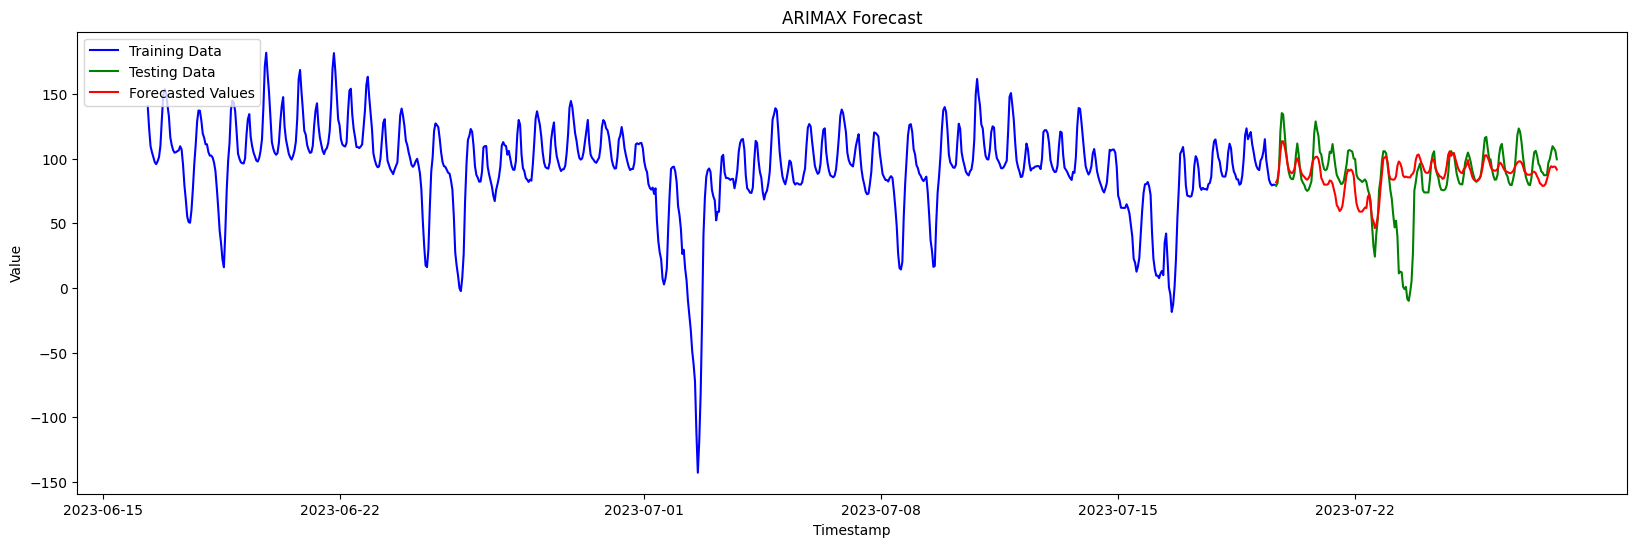

In [83]:
train_data, test_data = train_test_split(schweiz_df, 0.8) 

schweiz_model = train_arima_model(train_data, 'Schweiz [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= schweiz_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Schweiz [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Schweiz [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [84]:
schweiz_model = train_arima_model(schweiz_df, 'Schweiz [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
save_model('schweiz.pkl',schweiz_model)

##  Analysis for Tschechien

### ACF Analysis

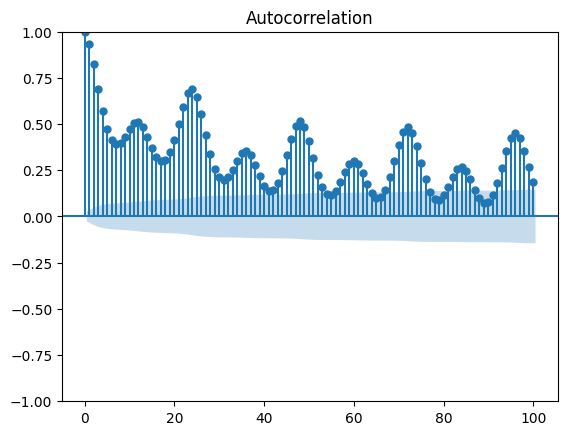

In [85]:
tschechien_df = data[['Timestamp','Tschechien [€/MWh] Originalauflösungen']].copy(deep=True)

tschechien_acf = plot_acf_graph(tschechien_df,'Tschechien [€/MWh] Originalauflösungen')

### PACF Analysis

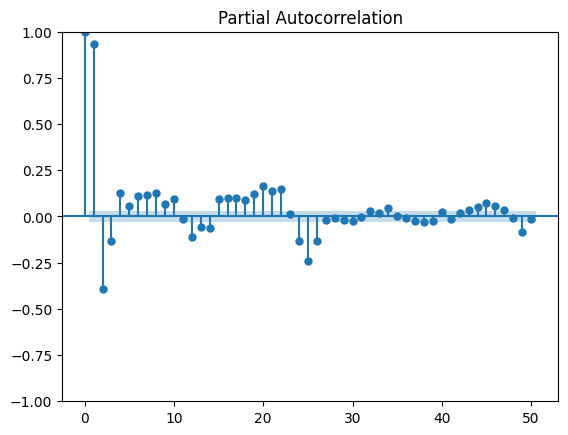

In [86]:
tschechien_pacf = plot_pacf_graph(tschechien_df,'Tschechien [€/MWh] Originalauflösungen')

### ADF Test

In [87]:
tschechien_adf = adf_check(tschechien_df,'Tschechien [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ tschechien_adf[0]},'p-value': {tschechien_adf[1]}")

'The values for ADF Statistic':-6.6007174799607835,'p-value': 6.7467987736509635e-09


### Seasonal Decomposition

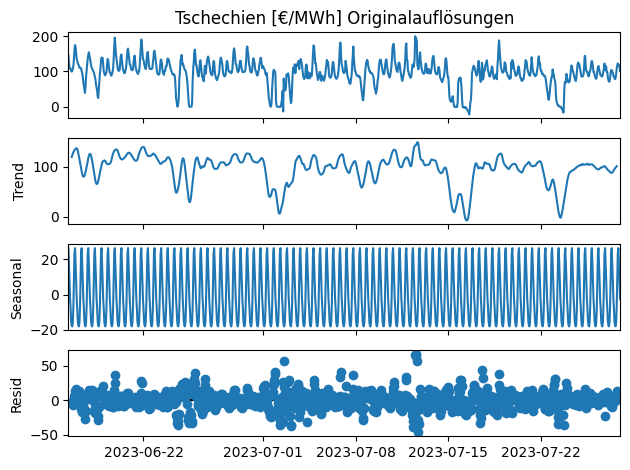

In [88]:
tschechien_df.index = pd.to_datetime(tschechien_df['Timestamp'])
tschechien_df = tschechien_df.tail(1000)
tschechien_seasonal_decompose = perform_seasonal_decomposition(tschechien_df,'Tschechien [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 32.96125334219403


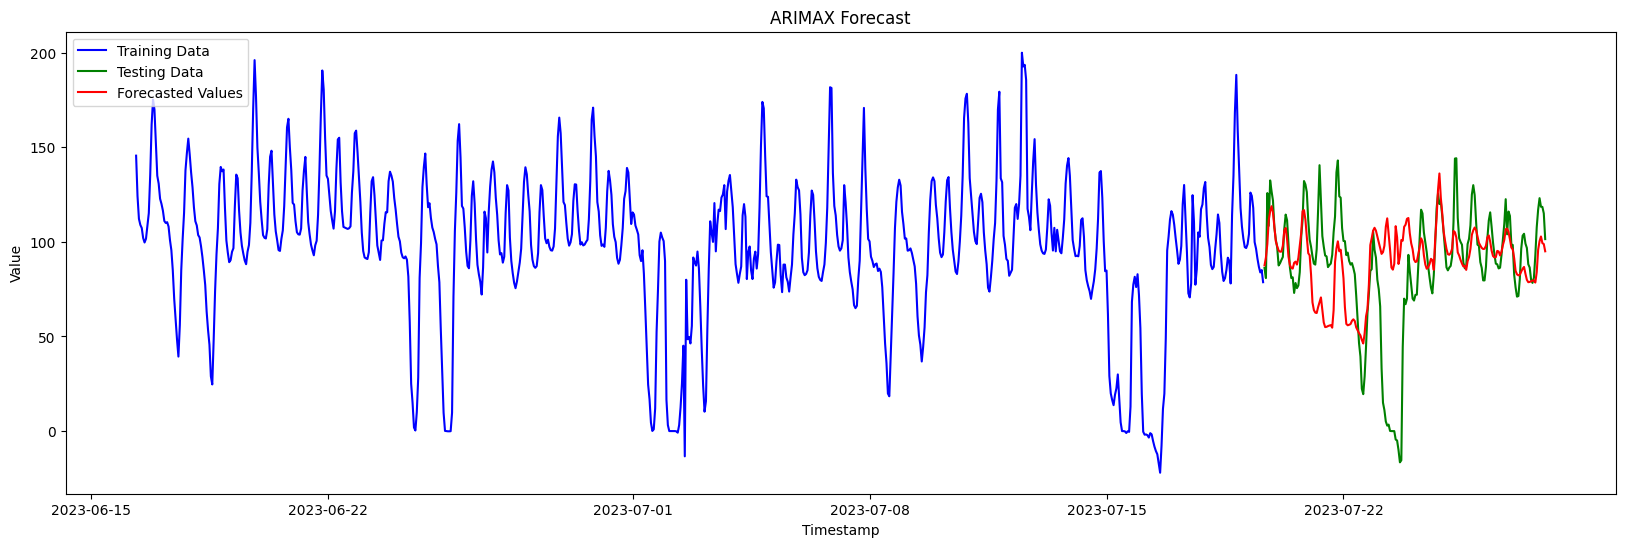

In [89]:
train_data, test_data = train_test_split(tschechien_df, 0.8) 

tschechien_model = train_arima_model(train_data, 'Tschechien [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= tschechien_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Tschechien [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Tschechien [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [90]:
# tschechien_model = train_arima_model(tschechien_df, 'Tschechien [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
# save_model('tschechien.pkl',tschechien_model)

##  Analysis for DE/AT/LU

### ACF Analysis

C:\Users\prati\.conda\envs\phelas\Lib\site-packages\statsmodels\tsa\stattools.py:691: RuntimeWarning:

invalid value encountered in divide

C:\Users\prati\.conda\envs\phelas\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning:




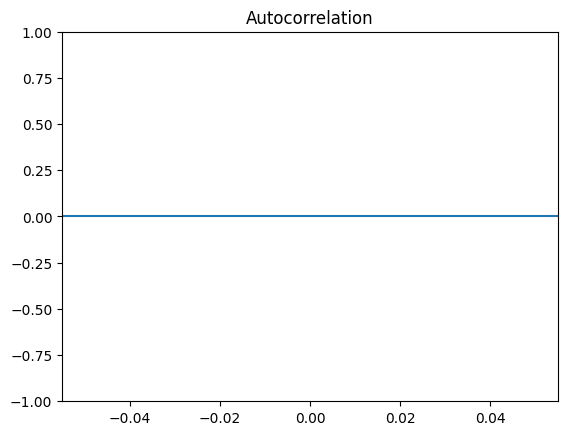

In [91]:
de_at_eu_df = data[['Timestamp','DE/AT/LU [€/MWh] Originalauflösungen']].copy(deep=True)

de_at_eu_acf = plot_acf_graph(de_at_eu_df,'DE/AT/LU [€/MWh] Originalauflösungen')

### PACF Analysis

C:\Users\prati\.conda\envs\phelas\Lib\site-packages\statsmodels\regression\linear_model.py:1489: ValueWarning:

Matrix is singular. Using pinv.



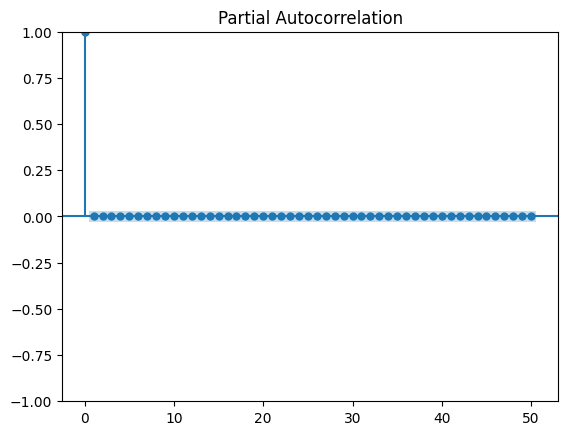

In [92]:
de_at_eu_pacf = plot_pacf_graph(de_at_eu_df,'DE/AT/LU [€/MWh] Originalauflösungen')

### ADF Test

The Prices are not present no cannot analyse

In [93]:
# de_at_eu_adf = adf_check(de_at_eu_df,'DE/AT/LU [€/MWh] Originalauflösungen')
# print(f"'The values for ADF Statistic':{ de_at_eu_adf[0]},'p-value': {de_at_eu_adf[1]}")

### Seasonal Decomposition

In [94]:
# de_at_eu_df.index = pd.to_datetime(de_at_eu_df['Timestamp'])
# de_at_eu_df = de_at_eu_df.tail(1000)
# de_at_eu_seasonal_decompose = perform_seasonal_decomposition(de_at_eu_df,'DE/AT/LU [€/MWh] Originalauflösungen',period=12)

### Model fitting and Evaluation

We cann' Train the model as the prices for the above data is zero

##  Analysis for Italien

### ACF Analysis

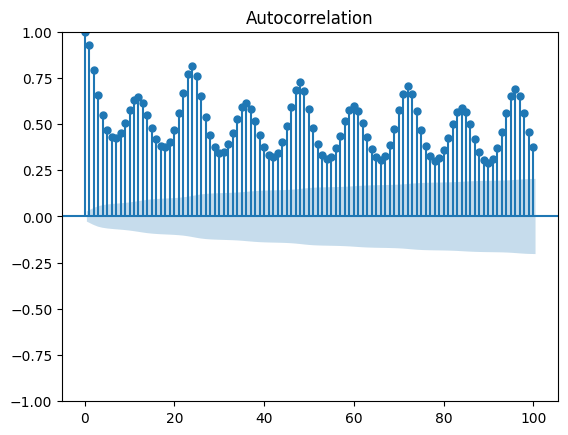

In [95]:
italien_df = data[['Timestamp','Italien (Nord) [€/MWh] Originalauflösungen']].copy(deep=True)

italien_acf = plot_acf_graph(italien_df,'Italien (Nord) [€/MWh] Originalauflösungen')

### PACF Analysis

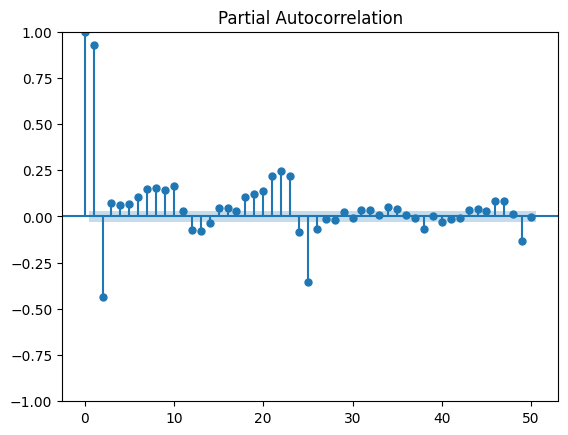

In [96]:
italien_pacf = plot_pacf_graph(italien_df,'Italien (Nord) [€/MWh] Originalauflösungen')

### ADF Test

In [97]:
italien_adf = adf_check(italien_df,'Italien (Nord) [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ italien_adf[0]},'p-value': {italien_adf[1]}")

'The values for ADF Statistic':-3.9479897024736337,'p-value': 0.0017087244504299108


### Seasonal Decomposition

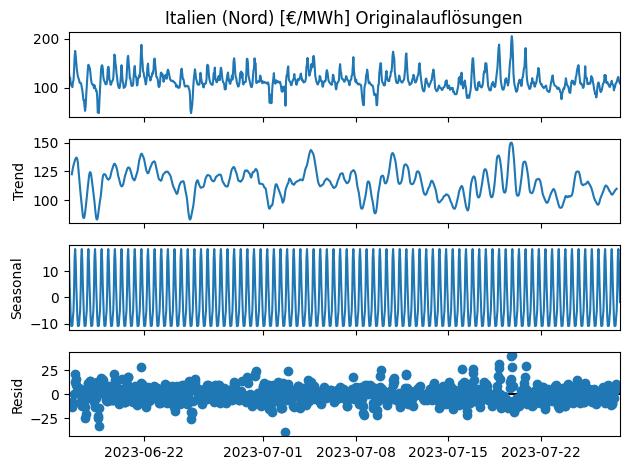

In [98]:
italien_df.index = pd.to_datetime(italien_df['Timestamp'])
italien_df = italien_df.tail(1000)
italien_seasonal_decompose = perform_seasonal_decomposition(italien_df,'Italien (Nord) [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 15.83454928627243


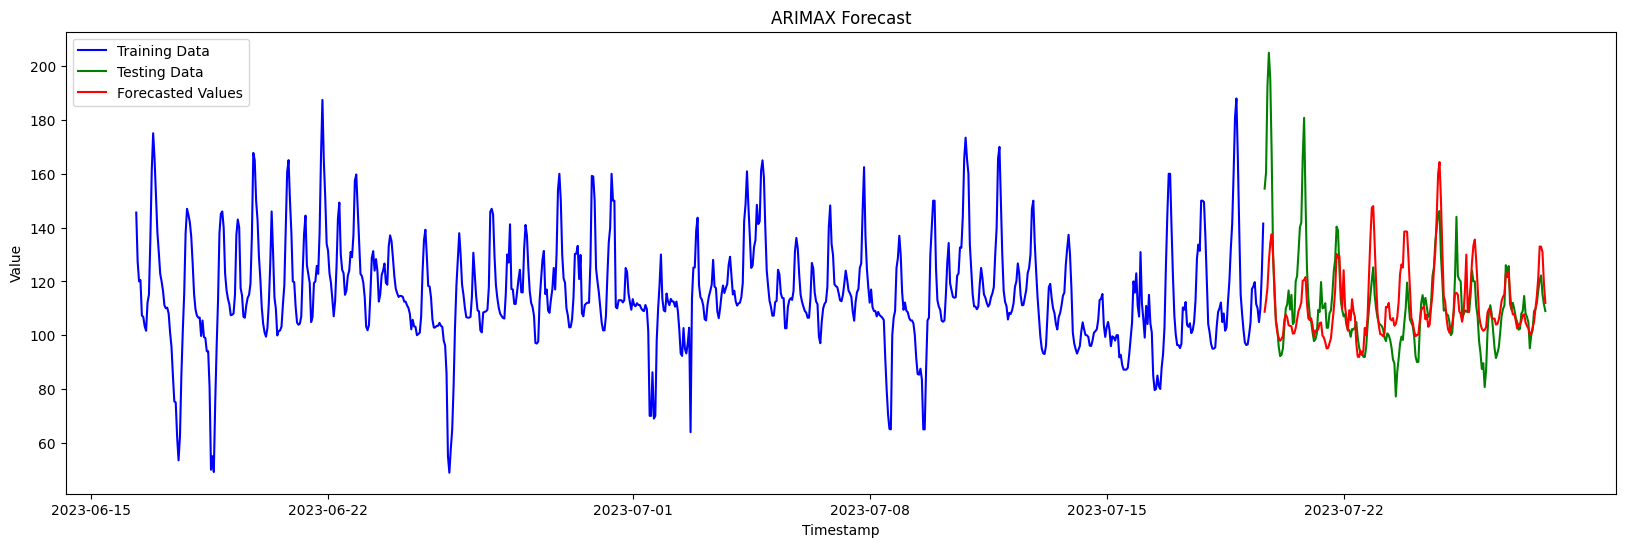

In [99]:
train_data, test_data = train_test_split(italien_df, 0.8) 

italien_model = train_arima_model(train_data, 'Italien (Nord) [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= italien_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Italien (Nord) [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Italien (Nord) [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [100]:
# italien_model = train_arima_model(italien_df, 'Italien (Nord) [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
# save_model('italien.pkl',italien_model)

##  Analysis for Slowenien

### ACF Analysis

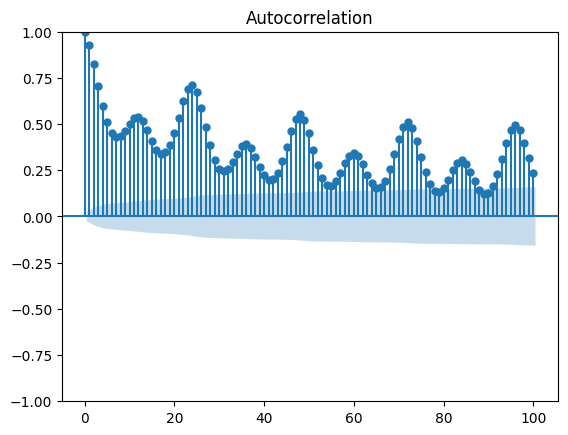

In [101]:
slowenien_df = data[['Timestamp','Slowenien [€/MWh] Originalauflösungen']].copy(deep=True)

slowenien_acf = plot_acf_graph(slowenien_df,'Slowenien [€/MWh] Originalauflösungen')

### PACF Analysis

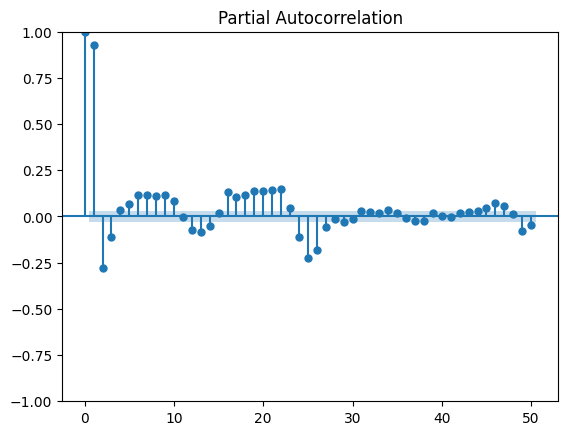

In [102]:
slowenien_pacf = plot_pacf_graph(slowenien_df,'Slowenien [€/MWh] Originalauflösungen')

### ADF Test

In [103]:
slowenien_adf = adf_check(slowenien_df,'Slowenien [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ slowenien_adf[0]},'p-value': {slowenien_adf[1]}")

'The values for ADF Statistic':-6.3432988764610965,'p-value': 2.7212028901729473e-08


### Seasonal Decomposition

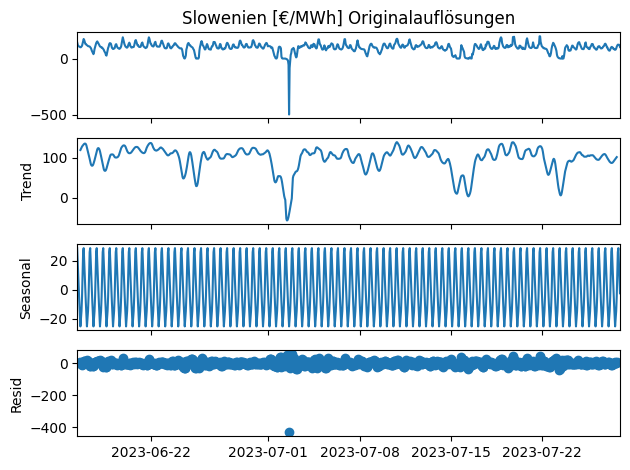

In [104]:
slowenien_df.index = pd.to_datetime(slowenien_df['Timestamp'])
slowenien_df = slowenien_df.tail(1000)
slowenien_seasonal_decompose = perform_seasonal_decomposition(slowenien_df,'Slowenien [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 33.99023132009368


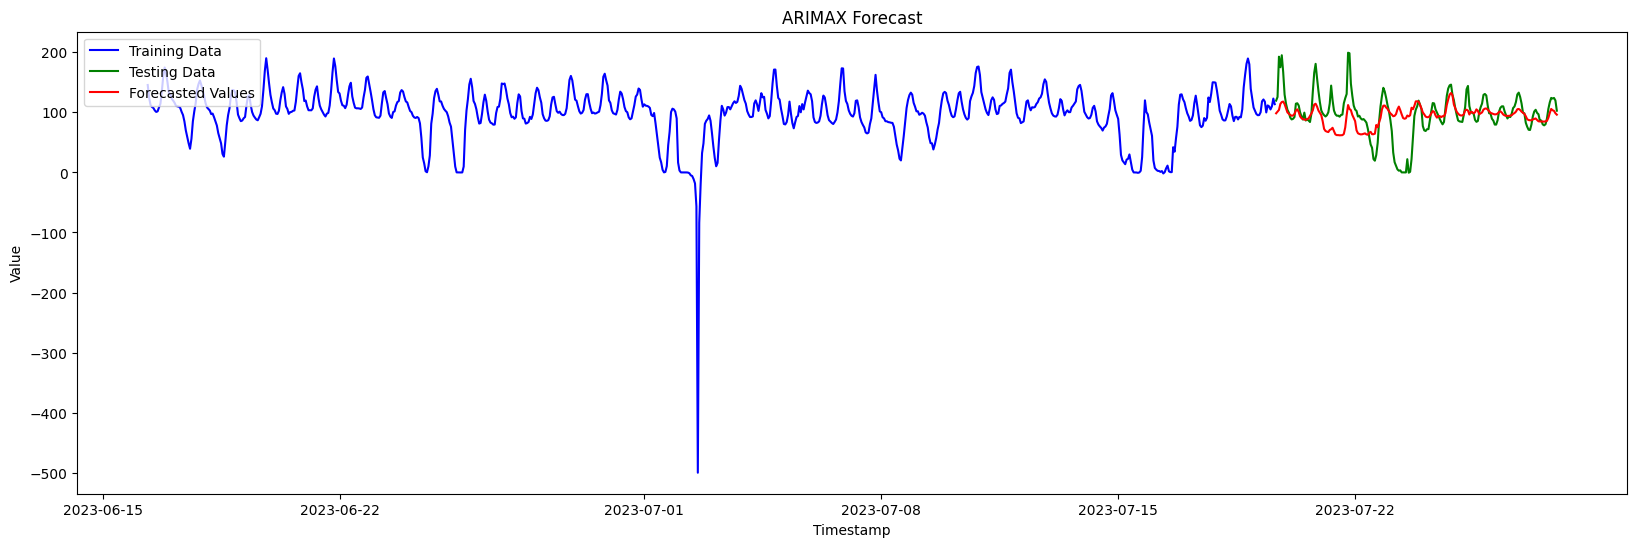

In [105]:
train_data, test_data = train_test_split(slowenien_df, 0.8) 

slowenien_model = train_arima_model(train_data, 'Slowenien [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= slowenien_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Slowenien [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Slowenien [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [106]:
# slowenien_model = train_arima_model(slowenien_df, 'Slowenien [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
# save_model('slowenien.pkl',slowenien_model)

##  Analysis for Ungarn

### ACF Analysis

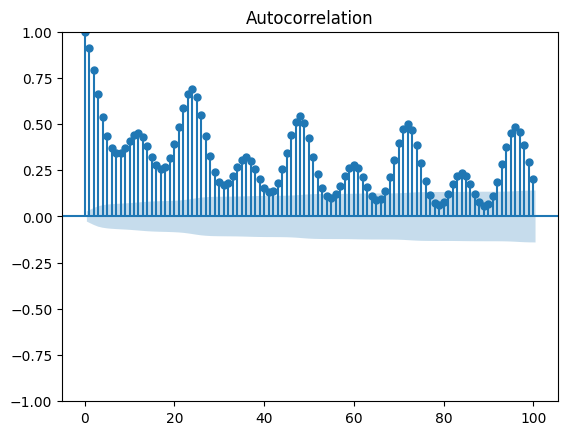

In [107]:
ungarn_df = data[['Timestamp','Ungarn [€/MWh] Originalauflösungen']].copy(deep=True)

ungarn_acf = plot_acf_graph(ungarn_df,'Ungarn [€/MWh] Originalauflösungen')

### PACF Analysis

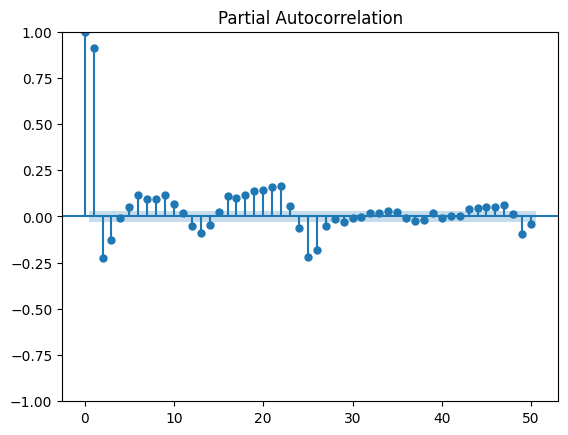

In [108]:
ungarn_pacf = plot_pacf_graph(ungarn_df,'Ungarn [€/MWh] Originalauflösungen')

### ADF Test

In [109]:
ungarn_adf = adf_check(ungarn_df,'Ungarn [€/MWh] Originalauflösungen')
print(f"'The values for ADF Statistic':{ ungarn_adf[0]},'p-value': {ungarn_adf[1]}")

'The values for ADF Statistic':-6.717679284087516,'p-value': 3.5478030479339806e-09


### Seasonal Decomposition

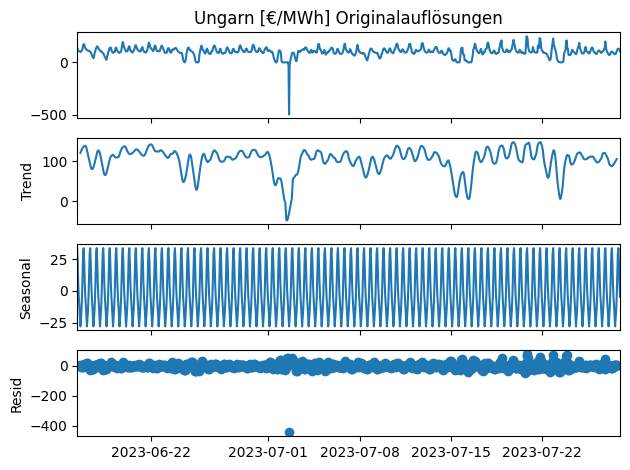

In [110]:
ungarn_df.index = pd.to_datetime(ungarn_df['Timestamp'])
ungarn_df = ungarn_df.tail(1000)
ungarn_seasonal_decompose = perform_seasonal_decomposition(ungarn_df,'Ungarn [€/MWh] Originalauflösungen',period=12)

### Model Selection
Since the data has seasonality. Hence SARIMA model is used. 

### Model fitting and Evaluation

Root Mean Squared Error (RMSE): 40.12409505394856


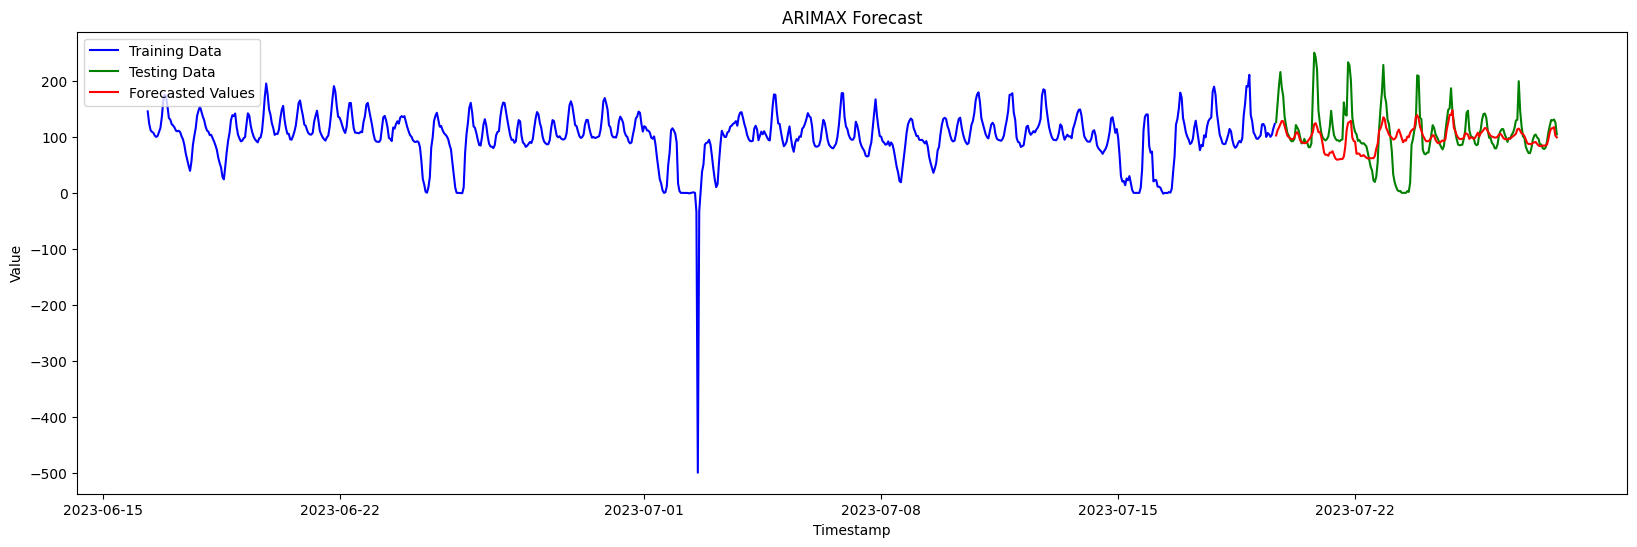

In [111]:
train_data, test_data = train_test_split(ungarn_df, 0.8) 

ungarn_model = train_arima_model(train_data, 'Ungarn [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
forecast_values, conf_int = model_forecast(trained_model= ungarn_model, forecast_period= len(test_data)) 
mse, rmse = accuracy_check(forecast_values,test_data['Ungarn [€/MWh] Originalauflösungen']) 
print("Root Mean Squared Error (RMSE):", rmse)
plot_forecast(train_data,test_data,forecast_values,'Ungarn [€/MWh] Originalauflösungen')

### Trainning the final model 
After the appropraite accuracy is acheived we train the model in the whole trainning and validation data

In [112]:
# ungarn_model = train_arima_model(ungarn_df, 'Ungarn [€/MWh] Originalauflösungen',p=0,q=0,d=0,P=2,Q=0,D=0,M=72)
# save_model('ungarn.pkl',ungarn_model)

# Forecasting Prices using Final Model

In [5]:
def load_model(model_name):
    with open(f'./model/{model_name}.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
        return loaded_model
    
def model_forecast(trained_model,forecast_period):
    return trained_model.predict(n_periods=forecast_period, return_conf_int=True)


def forecast_value(date,time):
    start_time = pd.to_datetime(f"{date} {time}")
    next_48_hours = pd.date_range(start=start_time, periods=48, freq='H')

    model = load_model('deutschland')
    anrainer_model = load_model('arainer')
    belgien_model = load_model('belgien')
    dänemark_1_model = load_model('dänemark_1')
    dänemark_2_model = load_model('dänemark_2')
    frankreich_model = load_model('frankreich')
    niederlande_model = load_model('niederlande')
    norwegen_model = load_model('norwegen')
    Österreich_model = load_model('Österreich')
    polen_model = load_model('polen')
    schweden_model = load_model('schweden')
    schweiz_model = load_model('schweiz')
    tschechien_model = load_model('tschechien')
    italien_model = load_model('italien')
    slowenien_model = load_model('slowenien')
    ungarn_model = load_model('ungarn')


    
    db_forecast_values, conf_int = model_forecast(trained_model= model, forecast_period= 48)
    anrainer_values, conf_int = model_forecast(trained_model= anrainer_model, forecast_period= 48)
    belgein_values, conf_int = model_forecast(trained_model= belgien_model, forecast_period= 48)
    dänemark_1_values, conf_int = model_forecast(trained_model= dänemark_1_model, forecast_period= 48)
    dänemark_2_values, conf_int = model_forecast(trained_model= dänemark_2_model, forecast_period= 48)
    frankreich_values, conf_int = model_forecast(trained_model= frankreich_model, forecast_period= 48)
    niederlande_values, conf_int = model_forecast(trained_model= niederlande_model, forecast_period= 48)
    norwegen_values, conf_int = model_forecast(trained_model= norwegen_model, forecast_period= 48)
    Österreich_values, conf_int = model_forecast(trained_model= Österreich_model, forecast_period= 48)
    polen_values, conf_int = model_forecast(trained_model= polen_model, forecast_period= 48)
    schweden_values, conf_int = model_forecast(trained_model= schweden_model, forecast_period= 48)
    schweiz_values, conf_int = model_forecast(trained_model= schweiz_model, forecast_period= 48)
    tschechien_values, conf_int = model_forecast(trained_model= tschechien_model, forecast_period= 48)
    italien_values, conf_int = model_forecast(trained_model= italien_model, forecast_period= 48)
    slowenien_values, conf_int = model_forecast(trained_model= slowenien_model, forecast_period= 48)
    ungarn_values, conf_int = model_forecast(trained_model= ungarn_model, forecast_period= 48)
    
    predicted_data = pd.DataFrame(data={
        'Timestamp':next_48_hours,
        'Deutschland/Luxemburg [€/MWh] Originalauflösungen':db_forecast_values,
        '∅ Anrainer DE/LU [€/MWh] Originalauflösungen':anrainer_values,
        'Belgien [€/MWh] Originalauflösungen':belgein_values,
        'Dänemark 1 [€/MWh] Originalauflösungen':dänemark_1_values,
        'Dänemark 2 [€/MWh] Originalauflösungen':dänemark_2_values,
        'Frankreich [€/MWh] Originalauflösungen':frankreich_values,
        'Niederlande [€/MWh] Originalauflösungen':niederlande_values,
        'Norwegen 2 [€/MWh] Originalauflösungen':norwegen_values,
        'Österreich [€/MWh] Originalauflösungen':Österreich_values,
        'Polen [€/MWh] Originalauflösungen':polen_values,
        'Schweden 4 [€/MWh] Originalauflösungen':schweden_values,
        'Schweiz [€/MWh] Originalauflösungen':schweiz_values,
        'Tschechien [€/MWh] Originalauflösungen':tschechien_values,
        'Italien (Nord) [€/MWh] Originalauflösungen':italien_values,
        'Slowenien [€/MWh] Originalauflösungen':slowenien_values,
        'Ungarn [€/MWh] Originalauflösungen':ungarn_values,
    })
    return predicted_data



    
    


In [6]:
def plot_forecast(forecast_data,col_name):
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    # Plot forecasted data
    ax.plot(forecast_data['Timestamp'], forecast_data[col_name], label=f'Forecasted {col_name}', color='blue')
    
    # Set plot title and labels
    ax.set_title(f'Forecasted {col_name}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Prices')
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Show the plot
    plt.show()

def get_forecasting(date,time):
    forecasted_df = forecast_value(date,time)
    col = forecasted_df.columns.to_list()
    col.remove('Timestamp')
    for i in col:
        plot_forecast(forecasted_df,i)

C:\Users\prati\AppData\Local\Temp\ipykernel_12828\2939888959.py:11: UserWarning:

Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



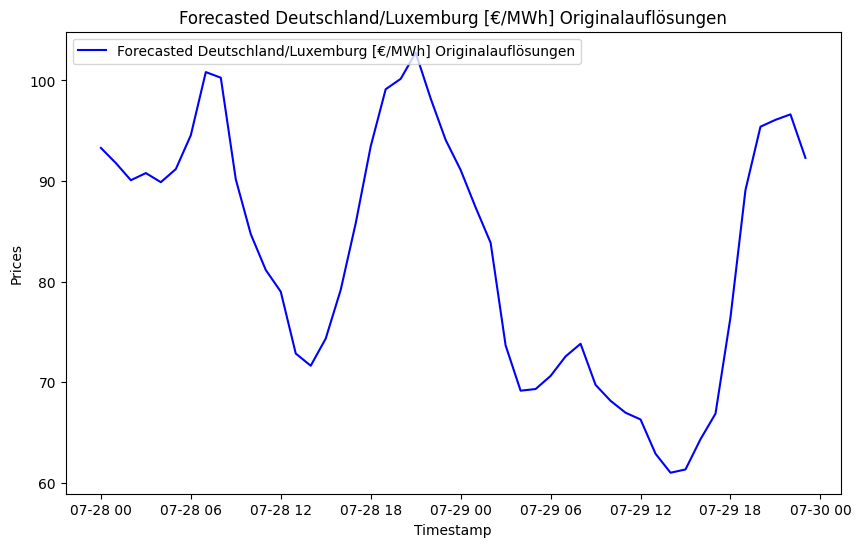

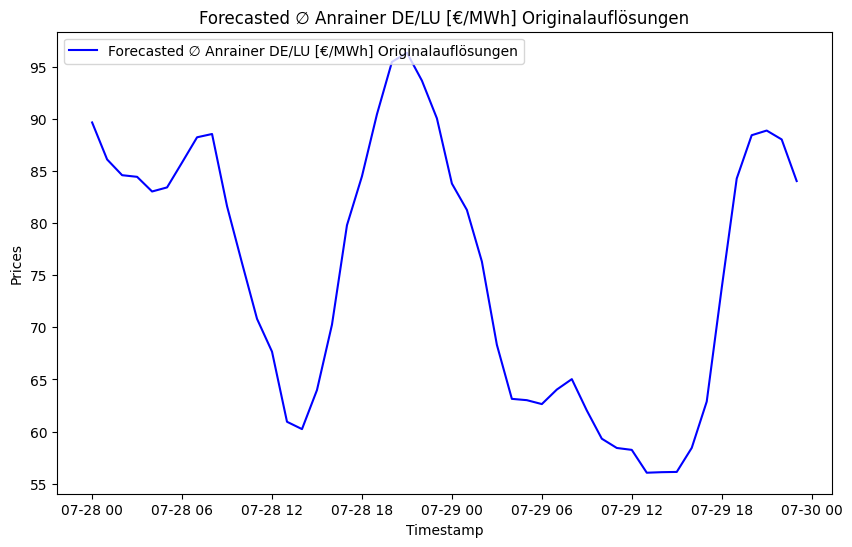

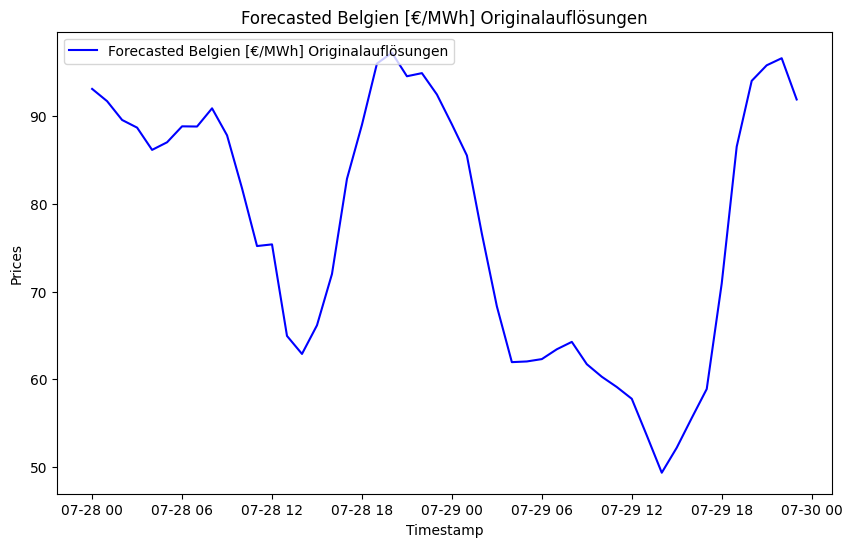

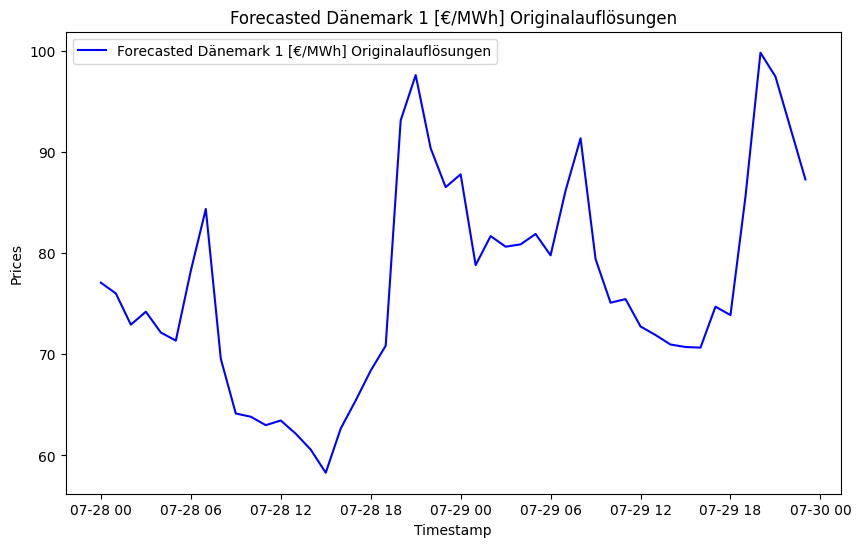

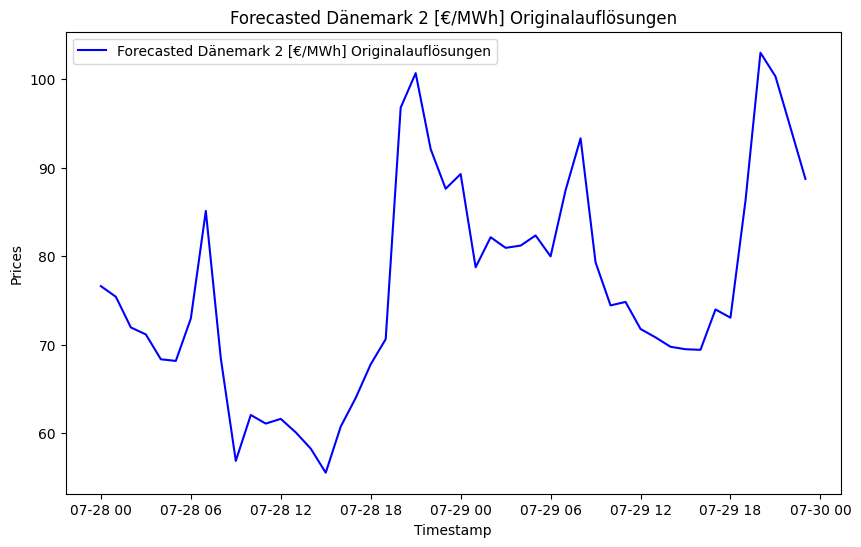

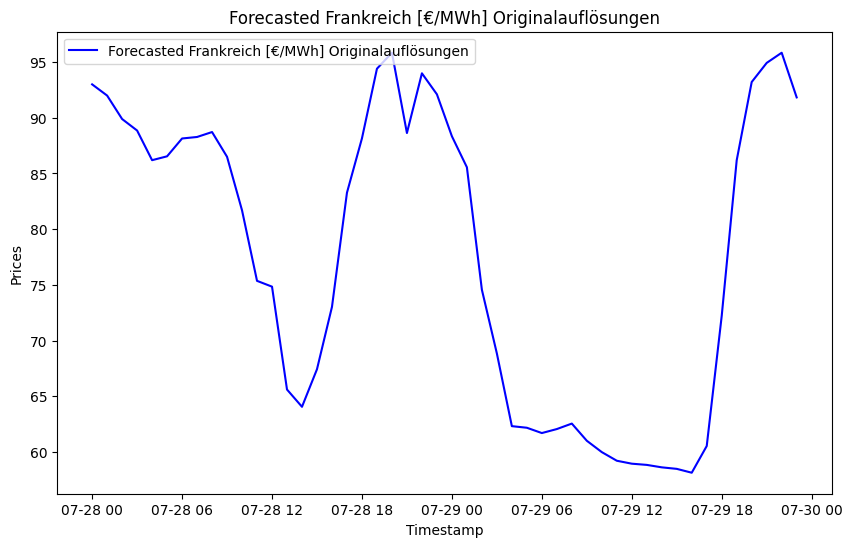

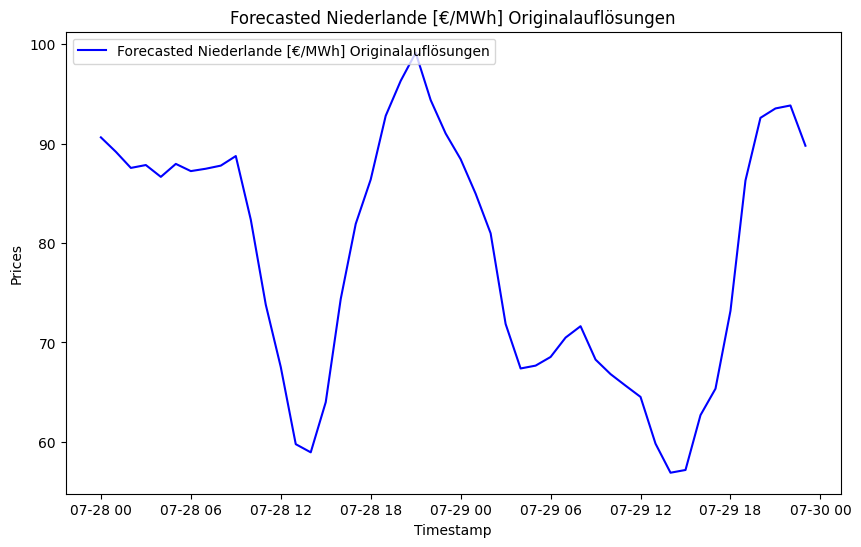

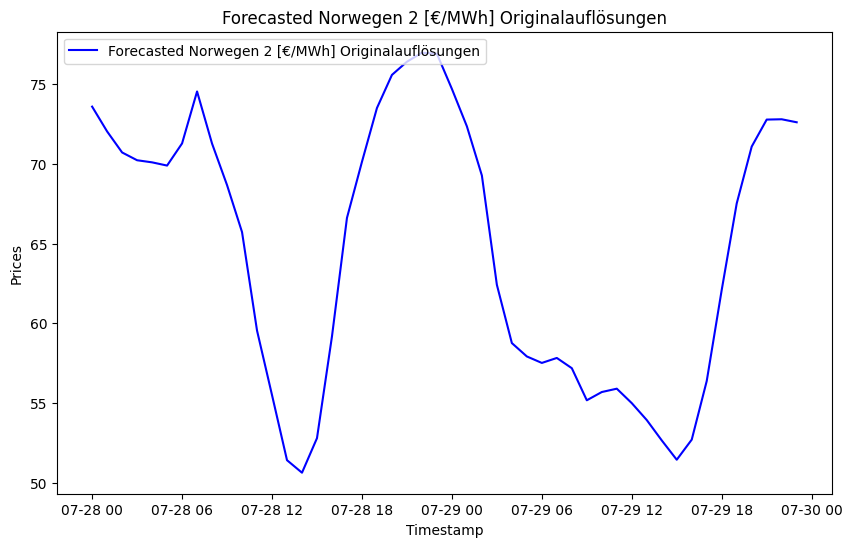

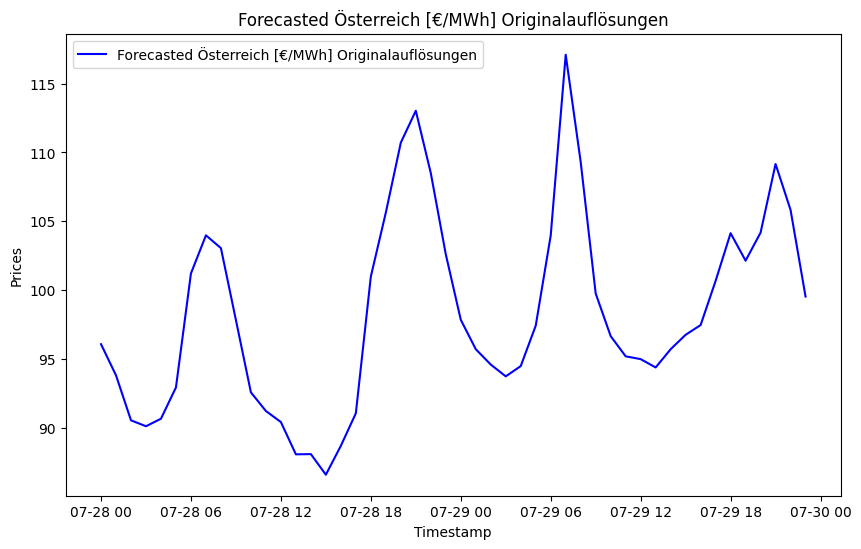

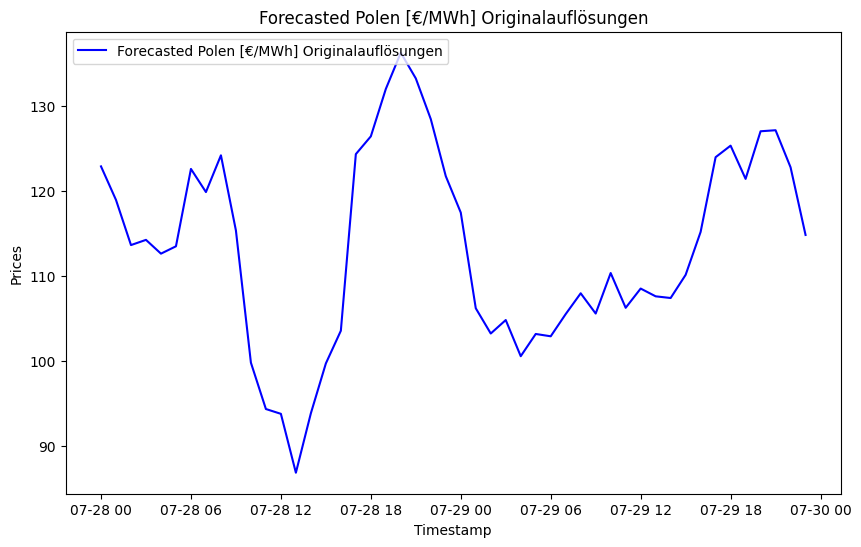

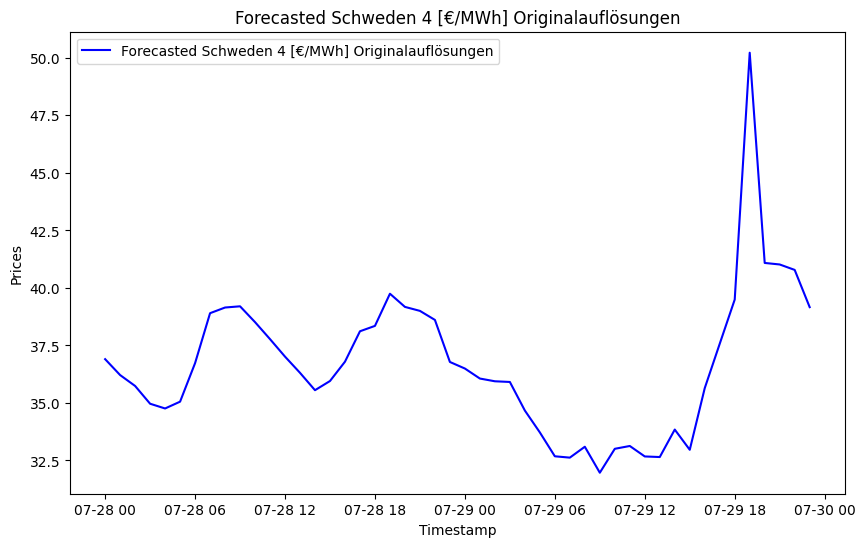

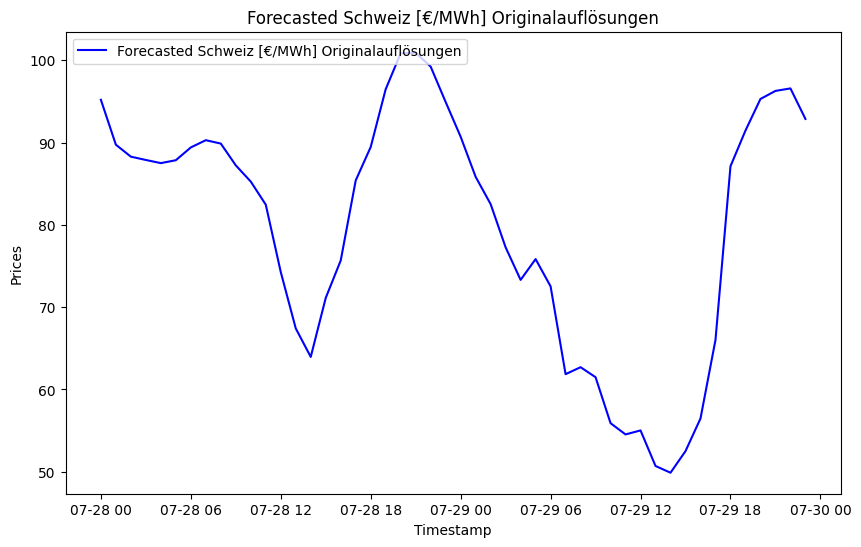

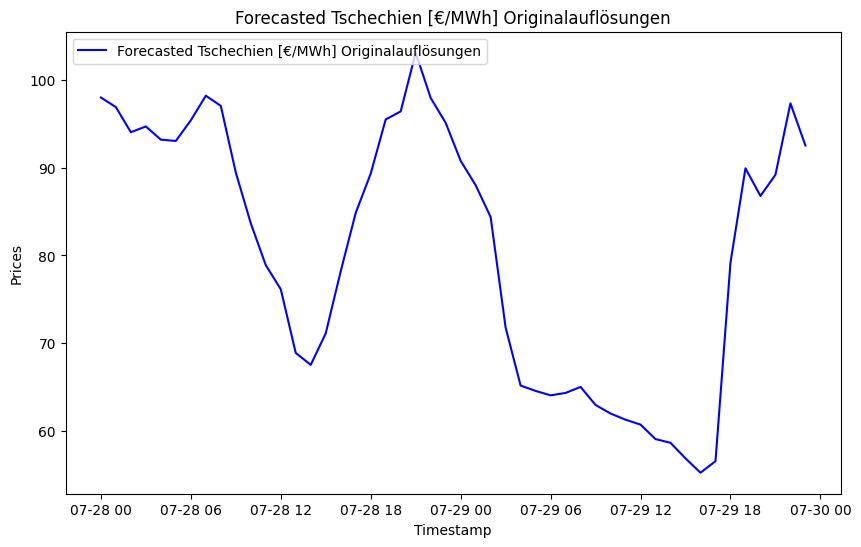

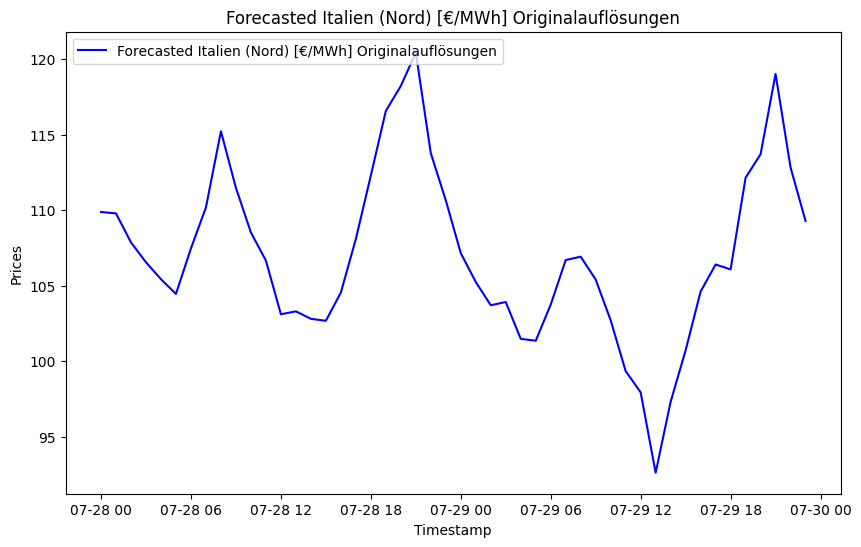

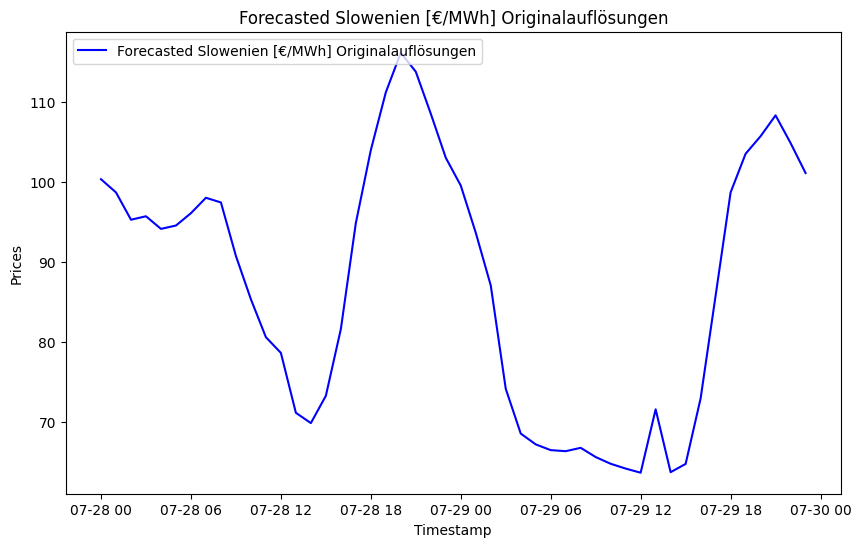

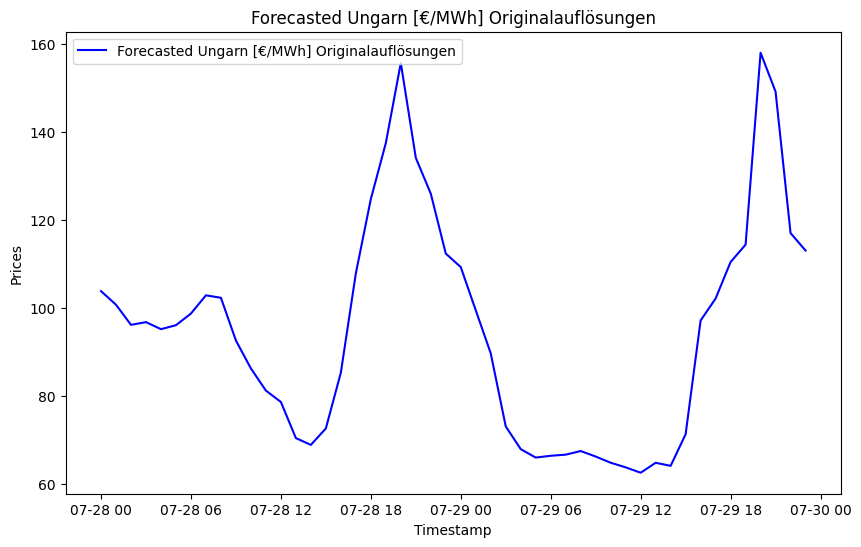

In [7]:
#Since the data consits of value tilll 27th july 2023 the forecasting is done from 28th august 2023
get_forecasting('28-07-2023','00:00:00')

# Additional data inputs to improve accuracy

The increase in the electricity demand also leads to increase in the price of electricity. 
The given data consists information about the electricity prices for the different countries, but we can also provide input of weather data or social media data.
We can use the weather data to predict the temperature in the countries, because if predicted weather is very much cold then, we can assume that large units of electricity would be consumed due to the extensive use of heaters and if the temperature predicted is very hot for a country then, we can assume that large units of electricity would be consumed  due to the use of air conditioner.

We can also use the social media data and perform the sentimental analysis, such that we get to know the impact of news or newly introduced policies on the electricity demand. If a new electricity policy is introduced then by sentimental analysis we get the knowledge about the impact of the policy on the demand of electricity and get to know about the increase or decrease in the demand for the electricity. 

# Models Strength, Weakness and Potential Improvements

The model used for prediction is Sarima model as the above data consisted seasonal patterns.

### Strengths of Model:
1. **Captures seasonal patterns**: The model is well suited for the seasonal data as it can capture the non linear patterns in the data.
2.  **Can include exogenous variable**: The model supports an additional variable, which can be used for more accurate prediction. As discused above we can ue the weather data, social media data.
3.  **Forecasting Accuracy**: The sarimax model provides roboust accuracy if used to predict short-term values.

### Weakness of Model:
1. **Complex Patterns**: The parameters like p,q,d,P,Q,D,M needs a lot of time for tunning and also requires the domain knowledge.
2.  **Limited Long term forecaasting**: The model is not suitable for long term prediction.
3.  **Data quality**: The model need stationary data with less trends. Hence checking if the data is stationary is an crucial task, else data smoothening techniques are required to smoothen the data.

### Potential Improvements:
1. **Feature engineering**: The additional features can be included in the model i.e the exogoneous variables.
2. **Ensemble approach**: We can model different Timeseries model and comnbine the prediction to get an firm prediction.
3. **Hyperparamter optimization**: We can also implement the Grid search for hyper parameter tunning like Bayesian optimization to streamline the process of optimization